In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!rm -rf /kaggle/working/p2w
!git clone --branch inpaint https://github.com/namirahrasul/P2W-dpmsolver.git /kaggle/working/p2w

Cloning into '/kaggle/working/p2w'...
remote: Enumerating objects: 1992, done.
remote: Counting objects: 100% (1769/1769), done.
remote: Compressing objects: 100% (1743/1743), done.
remote: Total 1992 (delta 23), reused 1749 (delta 19), pack-reused 223 (from 2)
Receiving objects: 100% (1992/1992), 14.78 MiB | 39.62 MiB/s, done.
Resolving deltas: 100% (102/102), done.


In [3]:
%%capture
!rm -rf /kaggle/working/miniconda
!wget -q https://repo.anaconda.com/miniconda/Miniconda3-py39_23.5.2-0-Linux-x86_64.sh -O miniconda.sh



In [4]:
!chmod +x miniconda.sh
!bash ./miniconda.sh -b -f -p /kaggle/working/miniconda

PREFIX=/kaggle/working/miniconda
Unpacking payload ...

Installing base environment...





Preparing transaction: - \ | / done
Executing transaction: \ | / - \ | / - \ | / - \ | / - \ | / - done
installation finished.
    You currently have a PYTHONPATH environment variable set. This may cause
    unexpected behavior when running the Python interpreter in Miniconda3.
    For best results, please verify that your PYTHONPATH only points to
    directories of packages that are compatible with the Python interpreter
    in Miniconda3: /kaggle/working/miniconda


In [5]:
# Verify Miniconda installation (check for python binary)
!ls -l /kaggle/working/miniconda/bin/python || echo "Python binary missing!"

lrwxrwxrwx 1 root root 9 Jul 12 17:35 /kaggle/working/miniconda/bin/python -> python3.9


In [6]:
# Ensure Conda binaries are executable
!chmod +x /kaggle/working/miniconda/bin/conda
!chmod +x /kaggle/working/miniconda/bin/python  # Explicitly make python executable
!chmod +x /kaggle/working/miniconda/etc/profile.d/conda.sh

In [7]:
# Add Conda to PATH
import os
os.environ['PATH'] = "/kaggle/working/miniconda/bin:" + os.environ['PATH']

In [8]:
%%capture
!conda install conda=25.1.1 -y

In [9]:
%%capture
# Initialize Conda
!conda init bash

# Create Conda environment with Python 3.9
!conda create -n p2wd python=3.9 -y

In [10]:
%%capture
!conda install -n p2wd mpi4py openmpi -y

In [11]:
%%capture
!source /kaggle/working/miniconda/etc/profile.d/conda.sh && conda activate p2wd && \
cd /kaggle/working/p2w && python setup.py

In [12]:
!mkdir /kaggle/working/p2w/ddpm_ckpt
!mkdir /kaggle/working/p2w/ddpm_ckpt/celeba
!mkdir /kaggle/working/p2w/ddpm_ckpt/imagenet

our checkpoint

In [13]:
alexnet_download_str = 'import os\n' \
'import torch\n' \
'import torchvision.models as models\n' \
'from torchvision.models import AlexNet_Weights\n' \
'import shutil\n' \
'from lpips import LPIPS\n' \
'import importlib.util\n' \
'\n' \
'# Set cache directory\n' \
'cache_dir = "/kaggle/working/p2w/.cache/torch/"\n' \
'os.environ["TORCH_HOME"] = cache_dir\n' \
'os.makedirs(os.path.join(cache_dir, "hub/checkpoints"), exist_ok=True)' \
'\n' \
'# Download AlexNet weights\n' \
'print("Pre-downloading AlexNet weights...")\n' \
'alexnet = models.alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)\n' \
'print("AlexNet weights downloaded successfully!")\n' \
'\n' \
'# Check for weights file\n' \
'weights_path = os.path.join(cache_dir, "hub/checkpoints/alexnet-owt-7be5be79.pth")\n' \
'print(f"Checking for weights at: {weights_path}")\n' \
'if os.path.exists(weights_path):\n' \
'    print(f"Weights file found at: {weights_path}")\n' \
'else:\n' \
'    print("Warning: Weights file not found. Saving manually...")\n' \
'    torch.save(alexnet.state_dict(), weights_path)\n' \
'    if os.path.exists(weights_path):\n' \
'        print(f"Weights saved to: {weights_path}")\n' \
'    else:\n' \
'        print("Failed to save weights.")\n' \
'# Preload LPIPS to ensure weights are available (bundled in package)\n'\
'print("Pre-downloading LPIPS weights...")\n'\
'lpips_model = LPIPS(net="alex")\n'\
'print("LPIPS weights downloaded successfully!")\n'\
'\n'\
'# Dynamically get LPIPS weights path from installed package (alternative to __file__)\n'\
'lpips_spec = importlib.util.find_spec("lpips")\n'\
'if lpips_spec is not None:\n'\
'    module_dir = os.path.dirname(lpips_spec.origin)\n'\
'    package_weights_dir = os.path.join(module_dir, "weights", "v0.1")\n'\
'    default_lpips_path = os.path.join(package_weights_dir, "alex.pth")\n'\
'    print(f"LPIPS source weights path: {default_lpips_path}")\n'\
'else:\n'\
'    print("Error: lpips module not found.")\n'\
'    default_lpips_path = None\n'\
'\n'\
'# Copy LPIPS weights to custom persistent path\n'\
'lpips_cache_dir = "/kaggle/working/p2w/.cache/lpips/"\n'\
'os.makedirs(lpips_cache_dir, exist_ok=True)\n'\
'custom_lpips_path = os.path.join(lpips_cache_dir, "alex.pth")  # Corrected filename to match default\n'\
'if default_lpips_path and os.path.exists(default_lpips_path):\n'\
'    shutil.copy(default_lpips_path, custom_lpips_path)\n'\
'    print(f"LPIPS weights copied to: {custom_lpips_path}")\n'\
'else:\n'\
'    print("Warning: LPIPS weights not found in package path.")\n'
with open('/kaggle/working/p2w/alexnet_download.py', 'w') as f:
    f.write(alexnet_download_str)

In [14]:
!source /kaggle/working/miniconda/etc/profile.d/conda.sh && conda activate p2wd && \
cd /kaggle/working/p2w && python alexnet_download.py

Pre-downloading AlexNet weights...
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /kaggle/working/p2w/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|█████████████████████████████████████████| 233M/233M [00:01<00:00, 189MB/s]
AlexNet weights downloaded successfully!
Checking for weights at: /kaggle/working/p2w/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
Weights file found at: /kaggle/working/p2w/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
Pre-downloading LPIPS weights...
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
/kaggle/working/miniconda/envs/p2wd/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/kaggle/working/miniconda/envs/p2wd/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum

In [15]:
import gdown
#imagenet(1M epoch)
file_id_64_i = '1OsL6UrYFUtmwBLcOdRViRcfTSdoIySjR'
file_id_256_i = '1fX0mcIWPAz7fd7tIWcVxFuPf65bqCjj3'
gdown.download(f'https://drive.google.com/uc?id={file_id_64_i}', '/kaggle/working/p2w/ddpm_ckpt/imagenet/64_ema_0.9999_1000000.pt', quiet=False)
gdown.download(f'https://drive.google.com/uc?id={file_id_256_i}', '/kaggle/working/p2w/ddpm_ckpt/imagenet/256_ema_0.9999_1000000.pt', quiet=False)
#celebahq(1M epoch)
file_id_64_c = '1GWdEYCqcGd55Gqkli80Z_O_t9cKuJWWP' 
file_id_256_c = '16Hz_Fis2PPmq2RrFy9Kj9WkZoXdsc3K0'
gdown.download(f'https://drive.google.com/uc?id={file_id_64_c}', '/kaggle/working/p2w/ddpm_ckpt/celeba/64_ema_0.9999_1000000.pt', quiet=False)
gdown.download(f'https://drive.google.com/uc?id={file_id_256_c}', '/kaggle/working/p2w/ddpm_ckpt/celeba/256_ema_0.9999_1000000.pt', quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1OsL6UrYFUtmwBLcOdRViRcfTSdoIySjR
From (redirected): https://drive.google.com/uc?id=1OsL6UrYFUtmwBLcOdRViRcfTSdoIySjR&confirm=t&uuid=838d5492-734e-484b-8abd-dc7114ecbb32
To: /kaggle/working/p2w/ddpm_ckpt/imagenet/64_ema_0.9999_1000000.pt
100%|██████████| 273M/273M [00:02<00:00, 93.1MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1fX0mcIWPAz7fd7tIWcVxFuPf65bqCjj3
From (redirected): https://drive.google.com/uc?id=1fX0mcIWPAz7fd7tIWcVxFuPf65bqCjj3&confirm=t&uuid=aba792ad-e6fc-4db8-bf25-85124100fbe7
To: /kaggle/working/p2w/ddpm_ckpt/imagenet/256_ema_0.9999_1000000.pt
100%|██████████| 374M/374M [00:01<00:00, 205MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1GWdEYCqcGd55Gqkli80Z_O_t9cKuJWWP
From (redirected): https://drive.google.com/uc?id=1GWdEYCqcGd55Gqkli80Z_O_t9cKuJWWP&confirm=t&uuid=3921ac57-ddf9-42bb-afbe-f0af4b1fa3e9
To: /kaggle/working/p2w/ddpm_ckpt/celeba/64_ema_0.9999_1000000.

'/kaggle/working/p2w/ddpm_ckpt/celeba/256_ema_0.9999_1000000.pt'

In [16]:
sampler_str = 'import torch\n' \
'import torch.nn.functional as F\n' \
'import math\n' \
'import os\n' \
'import torchvision.utils as tvu\n' \
'import inspect\n' \
'import traceback\n' \
'\n' \
'\n' \
'class NoiseScheduleVP:\n' \
'    def __init__(\n' \
'            self,\n' \
'            schedule="discrete",\n' \
'            betas=None,\n' \
'            alphas_cumprod=None,\n' \
'            continuous_beta_0=0.1,\n' \
'            continuous_beta_1=20.,\n' \
'            dtype=torch.float32,\n' \
'        ):\n' \
'        """Create a wrapper class for the forward SDE (VP type).\n' \
'\n' \
'        ***\n' \
'        Update: We support discrete-time diffusion models by implementing a picewise linear interpolation for log_alpha_t.\n' \
'                We recommend to use schedule="discrete" for the discrete-time diffusion models, especially for high-resolution images.\n' \
'        ***\n' \
'\n' \
'        The forward SDE ensures that the condition distribution q_{t|0}(x_t | x_0) = N ( alpha_t * x_0, sigma_t^2 * I ).\n' \
'        We further define lambda_t = log(alpha_t) - log(sigma_t), which is the half-logSNR (described in the DPM-Solver paper).\n' \
'        Therefore, we implement the functions for computing alpha_t, sigma_t and lambda_t. For t in [0, T], we have:\n' \
'\n' \
'            log_alpha_t = self.marginal_log_mean_coeff(t)\n' \
'            sigma_t = self.marginal_std(t)\n' \
'            lambda_t = self.marginal_lambda(t)\n' \
'\n' \
'        Moreover, as lambda(t) is an invertible function, we also support its inverse function:\n' \
'\n' \
'            t = self.inverse_lambda(lambda_t)\n' \
'\n' \
'        ===============================================================\n' \
'\n' \
'        We support both discrete-time DPMs (trained on n = 0, 1, ..., N-1) and continuous-time DPMs (trained on t in [t_0, T]).\n' \
'\n' \
'        1. For discrete-time DPMs:\n' \
'\n' \
'            For discrete-time DPMs trained on n = 0, 1, ..., N-1, we convert the discrete steps to continuous time steps by:\n' \
'                t_i = (i + 1) / N\n' \
'            e.g. for N = 1000, we have t_0 = 1e-3 and T = t_{N-1} = 1.\n' \
'            We solve the corresponding diffusion ODE from time T = 1 to time t_0 = 1e-3.\n' \
'\n' \
'            Args:\n' \
'                betas: A `torch.Tensor`. The beta array for the discrete-time DPM. (See the original DDPM paper for details)\n' \
'                alphas_cumprod: A `torch.Tensor`. The cumprod alphas for the discrete-time DPM. (See the original DDPM paper for details)\n' \
'\n' \
'            Note that we always have alphas_cumprod = cumprod(1 - betas). Therefore, we only need to set one of `betas` and `alphas_cumprod`.\n' \
'\n' \
'            **Important**:  Please pay special attention for the args for `alphas_cumprod`:\n' \
'                The `alphas_cumprod` is the \\hat{alpha_n} arrays in the notations of DDPM. Specifically, DDPMs assume that\n' \
'                    q_{t_n | 0}(x_{t_n} | x_0) = N ( \\sqrt{\\hat{alpha_n}} * x_0, (1 - \\hat{alpha_n}) * I ).\n' \
'                Therefore, the notation \\hat{alpha_n} is different from the notation alpha_t in DPM-Solver. In fact, we have\n' \
'                    alpha_{t_n} = \\sqrt{\\hat{alpha_n}},\n' \
'                and\n' \
'                    log(alpha_{t_n}) = 0.5 * log(\\hat{alpha_n}).\n' \
'\n' \
'\n' \
'        2. For continuous-time DPMs:\n' \
'\n' \
'            We support the linear VPSDE for the continuous time setting. The hyperparameters for the noise\n' \
'            schedule are the default settings in Yang Song\'s ScoreSDE:\n' \
'\n' \
'            Args:\n' \
'                beta_min: A `float` number. The smallest beta for the linear schedule.\n' \
'                beta_max: A `float` number. The largest beta for the linear schedule.\n' \
'                T: A `float` number. The ending time of the forward process.\n' \
'\n' \
'        ===============================================================\n' \
'\n' \
'        Args:\n' \
'            schedule: A `str`. The noise schedule of the forward SDE. \'discrete\' for discrete-time DPMs,\n' \
'                    \'linear\' for continuous-time DPMs.\n' \
'        Returns:\n' \
'            A wrapper object of the forward SDE (VP type).\n' \
'        \n' \
'        ===============================================================\n' \
'\n' \
'        Example:\n' \
'\n' \
'        # For discrete-time DPMs, given betas (the beta array for n = 0, 1, ..., N - 1):\n' \
'        >>> ns = NoiseScheduleVP(\'discrete\', betas=betas)\n' \
'\n' \
'        # For discrete-time DPMs, given alphas_cumprod (the \\hat{alpha_n} array for n = 0, 1, ..., N - 1):\n' \
'        >>> ns = NoiseScheduleVP(\'discrete\', alphas_cumprod=alphas_cumprod)\n' \
'\n' \
'        # For continuous-time DPMs (VPSDE), linear schedule:\n' \
'        >>> ns = NoiseScheduleVP(\'linear\', continuous_beta_0=0.1, continuous_beta_1=20.)\n' \
'\n' \
'        """\n' \
'\n' \
'        if schedule not in [\'discrete\', \'linear\']:\n' \
'            raise ValueError("Unsupported noise schedule {}. The schedule needs to be \'discrete\' or \'linear\'".format(schedule))\n' \
'\n' \
'        self.schedule = schedule\n' \
'        if schedule == \'discrete\':\n' \
'            if betas is not None:\n' \
'                log_alphas = 0.5 * torch.log(1 - betas).cumsum(dim=0)\n' \
'            else:\n' \
'                assert alphas_cumprod is not None\n' \
'                log_alphas = 0.5 * torch.log(alphas_cumprod)\n' \
'            self.alphas_cumprod = alphas_cumprod\n' \
'            self.T = 1.\n' \
'            self.log_alpha_array = self.numerical_clip_alpha(log_alphas).reshape((1, -1,)).to(dtype=dtype, device=alphas_cumprod.device)\n' \
'            self.total_N = self.log_alpha_array.shape[1]\n' \
'            self.t_array = torch.linspace(0., 1., self.total_N + 1)[1:].reshape((1, -1)).to(dtype=dtype, device=alphas_cumprod.device)\n' \
'        else:\n' \
'            self.T = 1.\n' \
'            self.total_N = 1000\n' \
'            self.beta_0 = continuous_beta_0\n' \
'            self.beta_1 = continuous_beta_1\n' \
'\n' \
'    def numerical_clip_alpha(self, log_alphas, clipped_lambda=-5.1):\n' \
'        """\n' \
'        For some beta schedules such as cosine schedule, the log-SNR has numerical isssues. \n' \
'        We clip the log-SNR near t=T within -5.1 to ensure the stability.\n' \
'        Such a trick is very useful for diffusion models with the cosine schedule, such as i-DDPM, guided-diffusion and GLIDE.\n' \
'        """\n' \
'        log_sigmas = 0.5 * torch.log(1. - torch.exp(2. * log_alphas))\n' \
'        lambs = log_alphas - log_sigmas\n' \
'        idx = torch.searchsorted(torch.flip(lambs, [0]), clipped_lambda)\n' \
'        if idx > 0:\n' \
'            log_alphas = log_alphas[:-idx]\n' \
'        return log_alphas\n' \
'\n' \
'    def marginal_log_mean_coeff(self, t):\n' \
'        """\n' \
'        Compute log(alpha_t) of a given continuous-time label t in [0, T].\n' \
'        """\n' \
'        if self.schedule == \'discrete\':\n' \
'            return interpolate_fn(t.reshape((-1, 1)), self.t_array.to(t.device), self.log_alpha_array.to(t.device)).reshape((-1))\n' \
'        elif self.schedule == \'linear\':\n' \
'            return -0.25 * t ** 2 * (self.beta_1 - self.beta_0) - 0.5 * t * self.beta_0\n' \
'\n' \
'    def marginal_alpha(self, t):\n' \
'        """\n' \
'        Compute alpha_t of a given continuous-time label t in [0, T].\n' \
'        """\n' \
'        return torch.exp(self.marginal_log_mean_coeff(t))\n' \
'\n' \
'    def marginal_std(self, t):\n' \
'        """\n' \
'        Compute sigma_t of a given continuous-time label t in [0, T].\n' \
'        """\n' \
'        return torch.sqrt(1. - torch.exp(2. * self.marginal_log_mean_coeff(t)))\n' \
'\n' \
'    def marginal_lambda(self, t):\n' \
'        """\n' \
'        Compute lambda_t = log(alpha_t) - log(sigma_t) of a given continuous-time label t in [0, T].\n' \
'        """\n' \
'        log_mean_coeff = self.marginal_log_mean_coeff(t)\n' \
'        log_std = 0.5 * torch.log(1. - torch.exp(2. * log_mean_coeff))\n' \
'        return log_mean_coeff - log_std\n' \
'\n' \
'    def inverse_lambda(self, lamb):\n' \
'        """\n' \
'        Compute the continuous-time label t in [0, T] of a given half-logSNR lambda_t.\n' \
'        """\n' \
'        if self.schedule == \'linear\':\n' \
'            tmp = 2. * (self.beta_1 - self.beta_0) * torch.logaddexp(-2. * lamb, torch.zeros((1,)).to(lamb))\n' \
'            Delta = self.beta_0**2 + tmp\n' \
'            return tmp / (torch.sqrt(Delta) + self.beta_0) / (self.beta_1 - self.beta_0)\n' \
'        elif self.schedule == \'discrete\':\n' \
'            log_alpha = -0.5 * torch.logaddexp(torch.zeros((1,)).to(lamb.device), -2. * lamb)\n' \
'            t = interpolate_fn(log_alpha.reshape((-1, 1)), torch.flip(self.log_alpha_array.to(lamb.device), [1]), torch.flip(self.t_array.to(lamb.device), [1]))\n' \
'            return t.reshape((-1,))\n' \
'\n' \
'\n' \
'def model_wrapper(\n' \
'    model,\n' \
'    noise_schedule,\n' \
'    model_type="noise",\n' \
'    model_kwargs={},\n' \
'    guidance_type="uncond",\n' \
'    condition=None,\n' \
'    unconditional_condition=None,\n' \
'    guidance_scale=1.,\n' \
'    classifier_fn=None,\n' \
'    classifier_kwargs={},\n' \
'):\n' \
'    """Create a wrapper function for the noise prediction model.\n' \
'\n' \
'    DPM-Solver needs to solve the continuous-time diffusion ODEs. For DPMs trained on discrete-time labels, we need to\n' \
'    firstly wrap the model function to a noise prediction model that accepts the continuous time as the input.\n' \
'\n' \
'    We support four types of the diffusion model by setting `model_type`:\n' \
'\n' \
'        1. "noise": noise prediction model. (Trained by predicting noise).\n' \
'\n' \
'        2. "x_start": data prediction model. (Trained by predicting the data x_0 at time 0).\n' \
'\n' \
'        3. "v": velocity prediction model. (Trained by predicting the velocity).\n' \
'            The "v" prediction is derivation detailed in Appendix D of [1], and is used in Imagen-Video [2].\n' \
'\n' \
'            [1] Salimans, Tim, and Jonathan Ho. "Progressive distillation for fast sampling of diffusion models."\n' \
'                arXiv preprint arXiv:2202.00512 (2022).\n' \
'            [2] Ho, Jonathan, et al. "Imagen Video: High Definition Video Generation with Diffusion Models."\n' \
'                arXiv preprint arXiv:2210.02303 (2022).\n' \
'    \n' \
'        4. "score": marginal score function. (Trained by denoising score matching).\n' \
'            Note that the score function and the noise prediction model follows a simple relationship:\n' \
'            ```\n' \
'                noise(x_t, t) = -sigma_t * score(x_t, t)\n' \
'            ```\n' \
'\n' \
'    We support three types of guided sampling by DPMs by setting `guidance_type`:\n' \
'        1. "uncond": unconditional sampling by DPMs.\n' \
'            The input `model` has the following format:\n' \
'            ``\n' \
'                model(x, t_input, **model_kwargs) -> noise | x_start | v | score\n' \
'            ``\n' \
'\n' \
'        2. "classifier": classifier guidance sampling [3] by DPMs and another classifier.\n' \
'            The input `model` has the following format:\n' \
'            ``\n' \
'                model(x, t_input, **model_kwargs) -> noise | x_start | v | score\n' \
'            `` \n' \
'\n' \
'            The input `classifier_fn` has the following format:\n' \
'            ``\n' \
'                classifier_fn(x, t_input, cond, **classifier_kwargs) -> logits(x, t_input, cond)\n' \
'            ``\n' \
'\n' \
'            [3] P. Dhariwal and A. Q. Nichol, "Diffusion models beat GANs on image synthesis,"\n' \
'                in Advances in Neural Information Processing Systems, vol. 34, 2021, pp. 8780-8794.\n' \
'\n' \
'        3. "classifier-free": classifier-free guidance sampling by conditional DPMs.\n' \
'            The input `model` has the following format:\n' \
'            ``\n' \
'                model(x, t_input, cond, **model_kwargs) -> noise | x_start | v | score\n' \
'            `` \n' \
'            And if cond == `unconditional_condition`, the model output is the unconditional DPM output.\n' \
'\n' \
'            [4] Ho, Jonathan, and Tim Salimans. "Classifier-free diffusion guidance."\n' \
'                arXiv preprint arXiv:2207.12598 (2022).\n' \
'        \n' \
'\n' \
'    The `t_input` is the time label of the model, which may be discrete-time labels (i.e. 0 to 999)\n' \
'    or continuous-time labels (i.e. epsilon to T).\n' \
'\n' \
'    We wrap the model function to accept only `x` and `t_continuous` as inputs, and outputs the predicted noise:\n' \
'    ``\n' \
'        def model_fn(x, t_continuous) -> noise:\n' \
'            t_input = get_model_input_time(t_continuous)\n' \
'            return noise_pred(model, x, t_input, **model_kwargs)         \n' \
'    ``\n' \
'    where `t_continuous` is the continuous time labels (i.e. epsilon to T). And we use `model_fn` for DPM-Solver.\n' \
'\n' \
'    ===============================================================\n' \
'\n' \
'    Args:\n' \
'        model: A diffusion model with the corresponding format described above.\n' \
'        noise_schedule: A noise schedule object, such as NoiseScheduleVP.\n' \
'        model_type: A `str`. The parameterization type of the diffusion model.\n' \
'                    "noise" or "x_start" or "v" or "score".\n' \
'        model_kwargs: A `dict`. A dict for the other inputs of the model function.\n' \
'        guidance_type: A `str`. The type of the guidance for sampling.\n' \
'                    "uncond" or "classifier" or "classifier-free".\n' \
'        condition: A pytorch tensor. The condition for the guided sampling.\n' \
'                    Only used for "classifier" or "classifier-free" guidance type.\n' \
'        unconditional_condition: A pytorch tensor. The condition for the unconditional sampling.\n' \
'                    Only used for "classifier-free" guidance type.\n' \
'        guidance_scale: A `float`. The scale for the guided sampling.\n' \
'        classifier_fn: A classifier function. Only used for the classifier guidance.\n' \
'        classifier_kwargs: A `dict`. A dict for the other inputs of the classifier function.\n' \
'    Returns:\n' \
'        A noise prediction model that accepts the noised data and the continuous time as the inputs.\n' \
'    """\n' \
'\n' \
'    def get_model_input_time(t_continuous):\n' \
'        """\n' \
'        Convert the continuous-time `t_continuous` (in [epsilon, T]) to the model input time.\n' \
'        For discrete-time DPMs, we convert `t_continuous` in [1 / N, 1] to `t_input` in [0, 1000 * (N - 1) / N].\n' \
'        For continuous-time DPMs, we just use `t_continuous`.\n' \
'        """\n' \
'        if noise_schedule.schedule == \'discrete\':\n' \
'            return (t_continuous - 1. / noise_schedule.total_N) * 1000.\n' \
'        else:\n' \
'            return t_continuous\n' \
'\n' \
'    def noise_pred_fn(x, t_continuous, cond=None):\n' \
'        t_input = get_model_input_time(t_continuous)\n' \
'        if cond is None:\n' \
'            output = model(x, t_input, **model_kwargs)\n' \
'        else:\n' \
'            output = model(x, t_input, cond, **model_kwargs)\n' \
'        if model_type == "noise":\n' \
'            return output\n' \
'        elif model_type == "x_start":\n' \
'            alpha_t, sigma_t = noise_schedule.marginal_alpha(t_continuous), noise_schedule.marginal_std(t_continuous)\n' \
'            return (x - alpha_t * output) / sigma_t\n' \
'        elif model_type == "v":\n' \
'            alpha_t, sigma_t = noise_schedule.marginal_alpha(t_continuous), noise_schedule.marginal_std(t_continuous)\n' \
'            return alpha_t * output + sigma_t * x\n' \
'        elif model_type == "score":\n' \
'            sigma_t = noise_schedule.marginal_std(t_continuous)\n' \
'            return -sigma_t * output\n' \
'\n' \
'    def cond_grad_fn(x, t_input):\n' \
'        """\n' \
'        Compute the gradient of the classifier, i.e. nabla_{x} log p_t(cond | x_t).\n' \
'        """\n' \
'        with torch.enable_grad():\n' \
'            x_in = x.detach().requires_grad_(True)\n' \
'            log_prob = classifier_fn(x_in, t_input, condition, **classifier_kwargs)\n' \
'            return torch.autograd.grad(log_prob.sum(), x_in)[0]\n' \
'\n' \
'    def model_fn(x, t_continuous):\n' \
'        """\n' \
'        The noise predicition model function that is used for DPM-Solver.\n' \
'        """\n' \
'        if guidance_type == "uncond":\n' \
'            return noise_pred_fn(x, t_continuous)\n' \
'        elif guidance_type == "classifier":\n' \
'            assert classifier_fn is not None\n' \
'            t_input = get_model_input_time(t_continuous)\n' \
'            cond_grad = cond_grad_fn(x, t_input)\n' \
'            sigma_t = noise_schedule.marginal_std(t_continuous)\n' \
'            noise = noise_pred_fn(x, t_continuous)\n' \
'            return noise - guidance_scale * expand_dims(sigma_t, x.dim()) * cond_grad\n' \
'        elif guidance_type == "classifier-free":\n' \
'            if guidance_scale == 1. or unconditional_condition is None:\n' \
'                return noise_pred_fn(x, t_continuous, cond=condition)\n' \
'            else:\n' \
'                x_in = torch.cat([x] * 2)\n' \
'                t_in = torch.cat([t_continuous] * 2)\n' \
'                c_in = torch.cat([unconditional_condition, condition])\n' \
'                noise_uncond, noise = noise_pred_fn(x_in, t_in, cond=c_in).chunk(2)\n' \
'                return noise_uncond + guidance_scale * (noise - noise_uncond)\n' \
'\n' \
'    assert model_type in ["noise", "x_start", "v", "score"]\n' \
'    assert guidance_type in ["uncond", "classifier", "classifier-free"]\n' \
'    return model_fn\n' \
'\n' \
'\n' \
'class DPM_Solver:\n' \
'    def __init__(\n' \
'        self,\n' \
'        model_fn,\n' \
'        noise_schedule,\n' \
'        algorithm_type="dpmsolver++",\n' \
'        correcting_x0_fn=None,\n' \
'        correcting_xt_fn=None,\n' \
'        thresholding_max_val=1.,\n' \
'        dynamic_thresholding_ratio=0.995,\n' \
'    ):\n' \
'        """Construct a DPM-Solver.\n' \
'\n' \
'        We support both DPM-Solver (`algorithm_type="dpmsolver"`) and DPM-Solver++ (`algorithm_type="dpmsolver++"`).\n' \
'\n' \
'        We also support the "dynamic thresholding" method in Imagen[1]. For pixel-space diffusion models, you\n' \
'        can set both `algorithm_type="dpmsolver++"` and `correcting_x0_fn="dynamic_thresholding"` to use the\n' \
'        dynamic thresholding. The "dynamic thresholding" can greatly improve the sample quality for pixel-space\n' \
'        DPMs with large guidance scales. Note that the thresholding method is **unsuitable** for latent-space\n' \
'        DPMs (such as stable-diffusion).\n' \
'\n' \
'        To support advanced algorithms in image-to-image applications, we also support corrector functions for\n' \
'        both x0 and xt.\n' \
'\n' \
'        Args:\n' \
'            model_fn: A noise prediction model function which accepts the continuous-time input (t in [epsilon, T]):\n' \
'                ``\n' \
'                def model_fn(x, t_continuous):\n' \
'                    return noise\n' \
'                ``\n' \
'                The shape of `x` is `(batch_size, **shape)`, and the shape of `t_continuous` is `(batch_size,)`.\n' \
'            noise_schedule: A noise schedule object, such as NoiseScheduleVP.\n' \
'            algorithm_type: A `str`. Either "dpmsolver" or "dpmsolver++".\n' \
'            correcting_x0_fn: A `str` or a function with the following format:\n' \
'                ```\n' \
'                def correcting_x0_fn(x0, t):\n' \
'                    x0_new = ...\n' \
'                    return x0_new\n' \
'                ```\n' \
'                This function is to correct the outputs of the data prediction model at each sampling step. e.g.,\n' \
'                ```\n' \
'                x0_pred = data_pred_model(xt, t)\n' \
'                if correcting_x0_fn is not None:\n' \
'                    x0_pred = correcting_x0_fn(x0_pred, t)\n' \
'                xt_1 = update(x0_pred, xt, t)\n' \
'                ```\n' \
'                If `correcting_x0_fn="dynamic_thresholding"`, we use the dynamic thresholding proposed in Imagen[1].\n' \
'            correcting_xt_fn: A function with the following format:\n' \
'                ```\n' \
'                def correcting_xt_fn(xt, t, step):\n' \
'                    x_new = ...\n' \
'                    return x_new\n' \
'                ```\n' \
'                This function is to correct the intermediate samples xt at each sampling step. e.g.,\n' \
'                ```\n' \
'                xt = ...\n' \
'                xt = correcting_xt_fn(xt, t, step)\n' \
'                ```\n' \
'            thresholding_max_val: A `float`. The max value for thresholding.\n' \
'                Valid only when use `dpmsolver++` and `correcting_x0_fn="dynamic_thresholding"`.\n' \
'            dynamic_thresholding_ratio: A `float`. The ratio for dynamic thresholding (see Imagen[1] for details).\n' \
'                Valid only when use `dpmsolver++` and `correcting_x0_fn="dynamic_thresholding"`.\n' \
'\n' \
'        [1] Chitwan Saharia, William Chan, Saurabh Saxena, Lala Li, Jay Whang, Emily Denton, Seyed Kamyar Seyed Ghasemipour,\n' \
'            Burcu Karagol Ayan, S Sara Mahdavi, Rapha Gontijo Lopes, et al. Photorealistic text-to-image diffusion models\n' \
'            with deep language understanding. arXiv preprint arXiv:2205.11487, 2022b.\n' \
'        """\n' \
'        self.model = lambda x, t: model_fn(x, t.expand((x.shape[0])))\n' \
'        self.noise_schedule = noise_schedule\n' \
'        assert algorithm_type in ["dpmsolver", "dpmsolver++"]\n' \
'        self.algorithm_type = algorithm_type\n' \
'        if correcting_x0_fn == "dynamic_thresholding":\n' \
'            self.correcting_x0_fn = self.dynamic_thresholding_fn\n' \
'        else:\n' \
'            self.correcting_x0_fn = correcting_x0_fn\n' \
'        self.correcting_xt_fn = correcting_xt_fn\n' \
'        self.dynamic_thresholding_ratio = dynamic_thresholding_ratio\n' \
'        self.thresholding_max_val = thresholding_max_val\n' \
'        # Add attributes for saving intermediate images\n' \
'        self.save_intermediate_enabled = True  # Enable/disable saving\n' \
'        self.save_frequency = 10  # Save every 10 steps\n' \
'        self.intermediate_dir = os.path.join(os.getcwd(), "experiments", "celebahq", "intermediate_steps")\n' \
'        os.makedirs(self.intermediate_dir, exist_ok=True)\n' \
'        print(f"Intermediate images will be saved to: {self.intermediate_dir}")\n' \
'        # Image counter to track the number of images processed\n' \
'        self.image_counter = 0  # Reset counter at initialization\n' \
'\n' \
'    def save_intermediate(self, x, step, stage, device):\n' \
'        if not self.save_intermediate_enabled:\n' \
'            return\n' \
'        if step % self.save_frequency == 0:  # Save only every save_frequency steps\n' \
'            if x is None:\n' \
'                print(f"Warning: x is None at step {step}, stage {stage}")\n' \
'                return\n' \
'            try:\n' \
'                # Create a subdirectory for this image based on image_counter\n' \
'                image_dir = os.path.join(self.intermediate_dir, f"intermediate_steps_image_{self.image_counter}")\n' \
'                os.makedirs(image_dir, exist_ok=True)\n' \
'                # If x is a batch, save each image in the batch separately\n' \
'                if len(x.shape) == 4:  # Shape: (batch_size, channels, height, width)\n' \
'                    batch_size = x.shape[0]\n' \
'                    for batch_idx in range(batch_size):\n' \
'                        x_single = x[batch_idx:batch_idx+1]  # Shape: (1, channels, height, width)\n' \
'                        # Normalize x from [-1, 1] to [0, 1] for saving\n' \
'                        x_normalized = (x + 1) / 2\n' \
'                        filename = os.path.join(image_dir, f"batch_{batch_idx}_step_{step:03d}_{stage}.png")\n' \
'                        tvu.save_image(x_normalized.to(device), filename, nrow=1)\n' \
'                        # Get the line number of the calling code\n' \
'                        frame = inspect.currentframe().f_back\n' \
'                        line_number = frame.f_lineno\n' \
'                        print(f"Saved intermediate image: {filename} at line {line_number}")\n' \
'                        # Also log to a file\n' \
'                        with open(os.path.join(self.intermediate_dir, "save_log.txt"), "a") as log_file:\n' \
'                            log_file.write(f"Saved intermediate image: {filename} at line {line_number}\\n")\n' \
'                else:\n' \
'                    # Single image case (unlikely, but handle for completeness)\n' \
'                    x_normalized = (x + 1) / 2\n' \
'                    filename = os.path.join(image_dir, f"step_{step:03d}_{stage}.png")\n' \
'                    tvu.save_image(x_normalized.to(device), filename, nrow=1)\n' \
'                    frame = inspect.currentframe().f_back\n' \
'                    line_number = frame.f_lineno\n' \
'                    print(f"Saved intermediate image: {filename} at line {line_number}")\n' \
'                    with open(os.path.join(image_dir, "save_log.txt"), "a") as log_file:\n' \
'                        log_file.write(f"Saved intermediate image: {filename} at line {line_number}\\n")\n' \
'            except Exception as e:\n' \
'                print(f"Failed to save image {filename}: {str(e)}")\n' \
'\n' \
'\n' \
'    def dynamic_thresholding_fn(self, x0, t):\n' \
'        """\n' \
'        The dynamic thresholding method.\n' \
'        """\n' \
'        dims = x0.dim()\n' \
'        p = self.dynamic_thresholding_ratio\n' \
'        s = torch.quantile(torch.abs(x0).reshape((x0.shape[0], -1)), p, dim=1)\n' \
'        s = expand_dims(torch.maximum(s, self.thresholding_max_val * torch.ones_like(s).to(s.device)), dims)\n' \
'        x0 = torch.clamp(x0, -s, s) / s\n' \
'        return x0\n' \
'\n' \
'    def noise_prediction_fn(self, x, t):\n' \
'        """\n' \
'        Return the noise prediction model.\n' \
'        """\n' \
'        return self.model(x, t)\n' \
'\n' \
'    def data_prediction_fn(self, x, t):\n' \
'        """\n' \
'        Return the data prediction model (with corrector).\n' \
'        """\n' \
'        noise = self.noise_prediction_fn(x, t)\n' \
'        alpha_t, sigma_t = self.noise_schedule.marginal_alpha(t), self.noise_schedule.marginal_std(t)\n' \
'        x0 = (x - sigma_t * noise) / alpha_t\n' \
'        x0 = x0.clamp(-1, 1)\n' \
'        if self.correcting_x0_fn is not None:\n' \
'            x0 = self.correcting_x0_fn(x0, t)\n' \
'        return x0\n' \
'\n' \
'    def model_fn(self, x, t):\n' \
'        """\n' \
'        Convert the model to the noise prediction model or the data prediction model.\n' \
'        """\n' \
'        if self.algorithm_type == "dpmsolver++":\n' \
'            return self.data_prediction_fn(x, t)\n' \
'        else:\n' \
'            return self.noise_prediction_fn(x, t)\n' \
'\n' \
'    def get_time_steps(self, skip_type, t_T, t_0, N, device):\n' \
'        """Compute the intermediate time steps for sampling.\n' \
'\n' \
'        Args:\n' \
'            skip_type: A `str`. The type for the spacing of the time steps. We support three types:\n' \
'                - \'logSNR\': uniform logSNR for the time steps.\n' \
'                - \'time_uniform\': uniform time for the time steps. (**Recommended for high-resolutional data**.)\n' \
'                - \'time_quadratic\': quadratic time for the time steps. (Used in DDIM for low-resolutional data.)\n' \
'            t_T: A `float`. The starting time of the sampling (default is T).\n' \
'            t_0: A `float`. The ending time of the sampling (default is epsilon).\n' \
'            N: A `int`. The total number of the spacing of the time steps.\n' \
'            device: A torch device.\n' \
'        Returns:\n' \
'            A pytorch tensor of the time steps, with the shape (N + 1,).\n' \
'        """\n' \
'        if skip_type == \'logSNR\':\n' \
'            lambda_T = self.noise_schedule.marginal_lambda(torch.tensor(t_T).to(device))\n' \
'            lambda_0 = self.noise_schedule.marginal_lambda(torch.tensor(t_0).to(device))\n' \
'            logSNR_steps = torch.linspace(lambda_T.cpu().item(), lambda_0.cpu().item(), N + 1).to(device)\n' \
'            return self.noise_schedule.inverse_lambda(logSNR_steps)\n' \
'        elif skip_type == \'time_uniform\':\n' \
'            return torch.linspace(t_T, t_0, N + 1).to(device)\n' \
'        elif skip_type == \'time_quadratic\':\n' \
'            t_order = 2\n' \
'            t = torch.linspace(t_T**(1. / t_order), t_0**(1. / t_order), N + 1).pow(t_order).to(device)\n' \
'            return t\n' \
'        else:\n' \
'            raise ValueError("Unsupported skip_type {}, need to be \'logSNR\' or \'time_uniform\' or \'time_quadratic\'".format(skip_type))\n' \
'\n' \
'    def get_orders_and_timesteps_for_singlestep_solver(self, steps, order, skip_type, t_T, t_0, device):\n' \
'        """\n' \
'        Get the order of each step for sampling by the singlestep DPM-Solver.\n' \
'\n' \
'        We combine both DPM-Solver-1,2,3 to use all the function evaluations, which is named as "DPM-Solver-fast".\n' \
'        Given a fixed number of function evaluations by `steps`, the sampling procedure by DPM-Solver-fast is:\n' \
'            - If order == 1:\n' \
'                We take `steps` of DPM-Solver-1 (i.e. DDIM).\n' \
'            - If order == 2:\n' \
'                - Denote K = (steps // 2). We take K or (K + 1) intermediate time steps for sampling.\n' \
'                - If steps % 2 == 0, we use K steps of DPM-Solver-2.\n' \
'                - If steps % 2 == 1, we use K steps of DPM-Solver-2 and 1 step of DPM-Solver-1.\n' \
'            - If order == 3:\n' \
'                - Denote K = (steps // 3 + 1). We take K intermediate time steps for sampling.\n' \
'                - If steps % 3 == 0, we use (K - 2) steps of DPM-Solver-3, and 1 step of DPM-Solver-2 and 1 step of DPM-Solver-1.\n' \
'                - If steps % 3 == 1, we use (K - 1) steps of DPM-Solver-3 and 1 step of DPM-Solver-1.\n' \
'                - If steps % 3 == 2, we use (K - 1) steps of DPM-Solver-3 and 1 step of DPM-Solver-2.\n' \
'\n' \
'        ============================================\n' \
'        Args:\n' \
'            order: A `int`. The max order for the solver (2 or 3).\n' \
'            steps: A `int`. The total number of function evaluations (NFE).\n' \
'            skip_type: A `str`. The type for the spacing of the time steps. We support three types:\n' \
'                - \'logSNR\': uniform logSNR for the time steps.\n' \
'                - \'time_uniform\': uniform time for the time steps. (**Recommended for high-resolutional data**.)\n' \
'                - \'time_quadratic\': quadratic time for the time steps. (Used in DDIM for low-resolutional data.)\n' \
'            t_T: A `float`. The starting time of the sampling (default is T).\n' \
'            t_0: A `float`. The ending time of the sampling (default is epsilon).\n' \
'            device: A torch device.\n' \
'        Returns:\n' \
'            orders: A list of the solver order of each step.\n' \
'        """\n' \
'        if order == 3:\n' \
'            K = steps // 3 + 1\n' \
'            if steps % 3 == 0:\n' \
'                orders = [3,] * (K - 2) + [2, 1]\n' \
'            elif steps % 3 == 1:\n' \
'                orders = [3,] * (K - 1) + [1]\n' \
'            else:\n' \
'                orders = [3,] * (K - 1) + [2]\n' \
'        elif order == 2:\n' \
'            if steps % 2 == 0:\n' \
'                K = steps // 2\n' \
'                orders = [2,] * K\n' \
'            else:\n' \
'                K = steps // 2 + 1\n' \
'                orders = [2,] * (K - 1) + [1]\n' \
'        elif order == 1:\n' \
'            K = steps\n' \
'            orders = [1,] * steps\n' \
'        else:\n' \
'            raise ValueError("\'order\' must be \'1\' or \'2\' or \'3\'.")\n' \
'        if skip_type == \'logSNR\':\n' \
'            # To reproduce the results in DPM-Solver paper\n' \
'            timesteps_outer = self.get_time_steps(skip_type, t_T, t_0, K, device)\n' \
'        else:\n' \
'            timesteps_outer = self.get_time_steps(skip_type, t_T, t_0, steps, device)[torch.cumsum(torch.tensor([0,] + orders), 0).to(device)]\n' \
'        return timesteps_outer, orders\n' \
'\n' \
'    def denoise_to_zero_fn(self, x, s):\n' \
'        """\n' \
'        Denoise at the final step, which is equivalent to solve the ODE from lambda_s to infty by first-order discretization.\n' \
'        """\n' \
'        return self.data_prediction_fn(x, s)\n' \
'\n' \
'    def dpm_solver_first_update(self, x, s, t, model_s=None, return_intermediate=False):\n' \
'        """\n' \
'        DPM-Solver-1 (equivalent to DDIM) from time `s` to time `t`.\n' \
'\n' \
'        Args:\n' \
'            x: A pytorch tensor. The initial value at time `s`.\n' \
'            s: A pytorch tensor. The starting time, with the shape (1,).\n' \
'            t: A pytorch tensor. The ending time, with the shape (1,).\n' \
'            model_s: A pytorch tensor. The model function evaluated at time `s`.\n' \
'                If `model_s` is None, we evaluate the model by `x` and `s`; otherwise we directly use it.\n' \
'            return_intermediate: A `bool`. If true, also return the model value at time `s`.\n' \
'        Returns:\n' \
'            x_t: A pytorch tensor. The approximated solution at time `t`.\n' \
'        """\n' \
'        ns = self.noise_schedule\n' \
'        dims = x.dim()\n' \
'        lambda_s, lambda_t = ns.marginal_lambda(s), ns.marginal_lambda(t)\n' \
'        h = lambda_t - lambda_s\n' \
'        log_alpha_s, log_alpha_t = ns.marginal_log_mean_coeff(s), ns.marginal_log_mean_coeff(t)\n' \
'        sigma_s, sigma_t = ns.marginal_std(s), ns.marginal_std(t)\n' \
'        alpha_t = torch.exp(log_alpha_t)\n' \
'\n' \
'        if self.algorithm_type == "dpmsolver++":\n' \
'            phi_1 = torch.expm1(-h)\n' \
'            if model_s is None:\n' \
'                model_s = self.model_fn(x, s)\n' \
'            x_t = (\n' \
'                sigma_t / sigma_s * x\n' \
'                - alpha_t * phi_1 * model_s\n' \
'            )\n' \
'            if return_intermediate:\n' \
'                return x_t, {\'model_s\': model_s}\n' \
'            else:\n' \
'                return x_t\n' \
'        else:\n' \
'            phi_1 = torch.expm1(h)\n' \
'            if model_s is None:\n' \
'                model_s = self.model_fn(x, s)\n' \
'            x_t = (\n' \
'                torch.exp(log_alpha_t - log_alpha_s) * x\n' \
'                - (sigma_t * phi_1) * model_s\n' \
'            )\n' \
'            if return_intermediate:\n' \
'                return x_t, {\'model_s\': model_s}\n' \
'            else:\n' \
'                return x_t\n' \
'\n' \
'    def singlestep_dpm_solver_second_update(self, x, s, t, r1=0.5, model_s=None, return_intermediate=False, solver_type=\'dpmsolver\'):\n' \
'        """\n' \
'        Singlestep solver DPM-Solver-2 from time `s` to time `t`.\n' \
'\n' \
'        Args:\n' \
'            x: A pytorch tensor. The initial value at time `s`.\n' \
'            s: A pytorch tensor. The starting time, with the shape (1,).\n' \
'            t: A pytorch tensor. The ending time, with the shape (1,).\n' \
'            r1: A `float`. The hyperparameter of the second-order solver.\n' \
'            model_s: A pytorch tensor. The model function evaluated at time `s`.\n' \
'                If `model_s` is None, we evaluate the model by `x` and `s`; otherwise we directly use it.\n' \
'            return_intermediate: A `bool`. If true, also return the model value at time `s` and `s1` (the intermediate time).\n' \
'            solver_type: either \'dpmsolver\' or \'taylor\'. The type for the high-order solvers.\n' \
'                The type slightly impacts the performance. We recommend to use \'dpmsolver\' type.\n' \
'        Returns:\n' \
'            x_t: A pytorch tensor. The approximated solution at time `t`.\n' \
'        """\n' \
'        if solver_type not in [\'dpmsolver\', \'taylor\']:\n' \
'            raise ValueError("\'solver_type\' must be either \'dpmsolver\' or \'taylor\', got {}".format(solver_type))\n' \
'        if r1 is None:\n' \
'            r1 = 0.5\n' \
'        ns = self.noise_schedule\n' \
'        lambda_s, lambda_t = ns.marginal_lambda(s), ns.marginal_lambda(t)\n' \
'        h = lambda_t - lambda_s\n' \
'        lambda_s1 = lambda_s + r1 * h\n' \
'        s1 = ns.inverse_lambda(lambda_s1)\n' \
'        log_alpha_s, log_alpha_s1, log_alpha_t = ns.marginal_log_mean_coeff(s), ns.marginal_log_mean_coeff(s1), ns.marginal_log_mean_coeff(t)\n' \
'        sigma_s, sigma_s1, sigma_t = ns.marginal_std(s), ns.marginal_std(s1), ns.marginal_std(t)\n' \
'        alpha_s1, alpha_t = torch.exp(log_alpha_s1), torch.exp(log_alpha_t)\n' \
'\n' \
'        if self.algorithm_type == "dpmsolver++":\n' \
'            phi_11 = torch.expm1(-r1 * h)\n' \
'            phi_1 = torch.expm1(-h)\n' \
'\n' \
'            if model_s is None:\n' \
'                model_s = self.model_fn(x, s)\n' \
'            x_s1 = (\n' \
'                (sigma_s1 / sigma_s) * x\n' \
'                - (alpha_s1 * phi_11) * model_s\n' \
'            )\n' \
'            model_s1 = self.model_fn(x_s1, s1)\n' \
'            if solver_type == \'dpmsolver\':\n' \
'                x_t = (\n' \
'                    (sigma_t / sigma_s) * x\n' \
'                    - (alpha_t * phi_1) * model_s\n' \
'                    - (0.5 / r1) * (alpha_t * phi_1) * (model_s1 - model_s)\n' \
'                )\n' \
'            elif solver_type == \'taylor\':\n' \
'                x_t = (\n' \
'                    (sigma_t / sigma_s) * x\n' \
'                    - (alpha_t * phi_1) * model_s\n' \
'                    + (1. / r1) * (alpha_t * (phi_1 / h + 1.)) * (model_s1 - model_s)\n' \
'                )\n' \
'        else:\n' \
'            phi_11 = torch.expm1(r1 * h)\n' \
'            phi_1 = torch.expm1(h)\n' \
'\n' \
'            if model_s is None:\n' \
'                model_s = self.model_fn(x, s)\n' \
'            x_s1 = (\n' \
'                torch.exp(log_alpha_s1 - log_alpha_s) * x\n' \
'                - (sigma_s1 * phi_11) * model_s\n' \
'            )\n' \
'            model_s1 = self.model_fn(x_s1, s1)\n' \
'            if solver_type == \'dpmsolver\':\n' \
'                x_t = (\n' \
'                    torch.exp(log_alpha_t - log_alpha_s) * x\n' \
'                    - (sigma_t * phi_1) * model_s\n' \
'                    - (0.5 / r1) * (sigma_t * phi_1) * (model_s1 - model_s)\n' \
'                )\n' \
'            elif solver_type == \'taylor\':\n' \
'                x_t = (\n' \
'                    torch.exp(log_alpha_t - log_alpha_s) * x\n' \
'                    - (sigma_t * phi_1) * model_s\n' \
'                    - (1. / r1) * (sigma_t * (phi_1 / h - 1.)) * (model_s1 - model_s)\n' \
'                )\n' \
'        if return_intermediate:\n' \
'            return x_t, {\'model_s\': model_s, \'model_s1\': model_s1}\n' \
'        else:\n' \
'            return x_t\n' \
'\n' \
'    def singlestep_dpm_solver_third_update(self, x, s, t, r1=1./3., r2=2./3., model_s=None, model_s1=None, return_intermediate=False, solver_type=\'dpmsolver\'):\n' \
'        """\n' \
'        Singlestep solver DPM-Solver-3 from time `s` to time `t`.\n' \
'\n' \
'        Args:\n' \
'            x: A pytorch tensor. The initial value at time `s`.\n' \
'            s: A pytorch tensor. The starting time, with the shape (1,).\n' \
'            t: A pytorch tensor. The ending time, with the shape (1,).\n' \
'            r1: A `float`. The hyperparameter of the third-order solver.\n' \
'            r2: A `float`. The hyperparameter of the third-order solver.\n' \
'            model_s: A pytorch tensor. The model function evaluated at time `s`.\n' \
'                If `model_s` is None, we evaluate the model by `x` and `s`; otherwise we directly use it.\n' \
'            model_s1: A pytorch tensor. The model function evaluated at time `s1` (the intermediate time given by `r1`).\n' \
'                If `model_s1` is None, we evaluate the model at `s1`; otherwise we directly use it.\n' \
'            return_intermediate: A `bool`. If true, also return the model value at time `s`, `s1` and `s2` (the intermediate times).\n' \
'            solver_type: either \'dpmsolver\' or \'taylor\'. The type for the high-order solvers.\n' \
'                The type slightly impacts the performance. We recommend to use \'dpmsolver\' type.\n' \
'        Returns:\n' \
'            x_t: A pytorch tensor. The approximated solution at time `t`.\n' \
'        """\n' \
'        if solver_type not in [\'dpmsolver\', \'taylor\']:\n' \
'            raise ValueError("\'solver_type\' must be either \'dpmsolver\' or \'taylor\', got {}".format(solver_type))\n' \
'        if r1 is None:\n' \
'            r1 = 1. / 3.\n' \
'        if r2 is None:\n' \
'            r2 = 2. / 3.\n' \
'        ns = self.noise_schedule\n' \
'        lambda_s, lambda_t = ns.marginal_lambda(s), ns.marginal_lambda(t)\n' \
'        h = lambda_t - lambda_s\n' \
'        lambda_s1 = lambda_s + r1 * h\n' \
'        lambda_s2 = lambda_s + r2 * h\n' \
'        s1 = ns.inverse_lambda(lambda_s1)\n' \
'        s2 = ns.inverse_lambda(lambda_s2)\n' \
'        log_alpha_s, log_alpha_s1, log_alpha_s2, log_alpha_t = ns.marginal_log_mean_coeff(s), ns.marginal_log_mean_coeff(s1), ns.marginal_log_mean_coeff(s2), ns.marginal_log_mean_coeff(t)\n' \
'        sigma_s, sigma_s1, sigma_s2, sigma_t = ns.marginal_std(s), ns.marginal_std(s1), ns.marginal_std(s2), ns.marginal_std(t)\n' \
'        alpha_s1, alpha_s2, alpha_t = torch.exp(log_alpha_s1), torch.exp(log_alpha_s2), torch.exp(log_alpha_t)\n' \
'\n' \
'        if self.algorithm_type == "dpmsolver++":\n' \
'            phi_11 = torch.expm1(-r1 * h)\n' \
'            phi_12 = torch.expm1(-r2 * h)\n' \
'            phi_1 = torch.expm1(-h)\n' \
'            phi_22 = torch.expm1(-r2 * h) / (r2 * h) + 1.\n' \
'            phi_2 = phi_1 / h + 1.\n' \
'            phi_3 = phi_2 / h - 0.5\n' \
'\n' \
'            if model_s is None:\n' \
'                model_s = self.model_fn(x, s)\n' \
'            if model_s1 is None:\n' \
'                x_s1 = (\n' \
'                    (sigma_s1 / sigma_s) * x\n' \
'                    - (alpha_s1 * phi_11) * model_s\n' \
'                )\n' \
'                model_s1 = self.model_fn(x_s1, s1)\n' \
'            x_s2 = (\n' \
'                (sigma_s2 / sigma_s) * x\n' \
'                - (alpha_s2 * phi_12) * model_s\n' \
'                + r2 / r1 * (alpha_s2 * phi_22) * (model_s1 - model_s)\n' \
'            )\n' \
'            model_s2 = self.model_fn(x_s2, s2)\n' \
'            if solver_type == \'dpmsolver\':\n' \
'                x_t = (\n' \
'                    (sigma_t / sigma_s) * x\n' \
'                    - (alpha_t * phi_1) * model_s\n' \
'                    + (1. / r2) * (alpha_t * phi_2) * (model_s2 - model_s)\n' \
'                )\n' \
'            elif solver_type == \'taylor\':\n' \
'                D1_0 = (1. / r1) * (model_s1 - model_s)\n' \
'                D1_1 = (1. / r2) * (model_s2 - model_s)\n' \
'                D1 = (r2 * D1_0 - r1 * D1_1) / (r2 - r1)\n' \
'                D2 = 2. * (D1_1 - D1_0) / (r2 - r1)\n' \
'                x_t = (\n' \
'                    (sigma_t / sigma_s) * x\n' \
'                    - (alpha_t * phi_1) * model_s\n' \
'                    + (alpha_t * phi_2) * D1\n' \
'                    - (alpha_t * phi_3) * D2\n' \
'                )\n' \
'        else:\n' \
'            phi_11 = torch.expm1(r1 * h)\n' \
'            phi_12 = torch.expm1(r2 * h)\n' \
'            phi_1 = torch.expm1(h)\n' \
'            phi_22 = torch.expm1(r2 * h) / (r2 * h) - 1.\n' \
'            phi_2 = phi_1 / h - 1.\n' \
'            phi_3 = phi_2 / h - 0.5\n' \
'\n' \
'            if model_s is None:\n' \
'                model_s = self.model_fn(x, s)\n' \
'            if model_s1 is None:\n' \
'                x_s1 = (\n' \
'                    (torch.exp(log_alpha_s1 - log_alpha_s)) * x\n' \
'                    - (sigma_s1 * phi_11) * model_s\n' \
'                )\n' \
'                model_s1 = self.model_fn(x_s1, s1)\n' \
'            x_s2 = (\n' \
'                (torch.exp(log_alpha_s2 - log_alpha_s)) * x\n' \
'                - (sigma_s2 * phi_12) * model_s\n' \
'                - r2 / r1 * (sigma_s2 * phi_22) * (model_s1 - model_s)\n' \
'            )\n' \
'            model_s2 = self.model_fn(x_s2, s2)\n' \
'            if solver_type == \'dpmsolver\':\n' \
'                x_t = (\n' \
'                    (torch.exp(log_alpha_t - log_alpha_s)) * x\n' \
'                    - (sigma_t * phi_1) * model_s\n' \
'                    - (1. / r2) * (sigma_t * phi_2) * (model_s2 - model_s)\n' \
'                )\n' \
'            elif solver_type == \'taylor\':\n' \
'                D1_0 = (1. / r1) * (model_s1 - model_s)\n' \
'                D1_1 = (1. / r2) * (model_s2 - model_s)\n' \
'                D1 = (r2 * D1_0 - r1 * D1_1) / (r2 - r1)\n' \
'                D2 = 2. * (D1_1 - D1_0) / (r2 - r1)\n' \
'                x_t = (\n' \
'                    (torch.exp(log_alpha_t - log_alpha_s)) * x\n' \
'                    - (sigma_t * phi_1) * model_s\n' \
'                    - (sigma_t * phi_2) * D1\n' \
'                    - (sigma_t * phi_3) * D2\n' \
'                )\n' \
'\n' \
'        if return_intermediate:\n' \
'            return x_t, {\'model_s\': model_s, \'model_s1\': model_s1, \'model_s2\': model_s2}\n' \
'        else:\n' \
'            return x_t\n' \
'\n' \
'    def multistep_dpm_solver_second_update(self, x, model_prev_list, t_prev_list, t, solver_type="dpmsolver"):\n' \
'        """\n' \
'        Multistep solver DPM-Solver-2 from time `t_prev_list[-1]` to time `t`.\n' \
'\n' \
'        Args:\n' \
'            x: A pytorch tensor. The initial value at time `s`.\n' \
'            model_prev_list: A list of pytorch tensor. The previous computed model values.\n' \
'            t_prev_list: A list of pytorch tensor. The previous times, each time has the shape (1,)\n' \
'            t: A pytorch tensor. The ending time, with the shape (1,).\n' \
'            solver_type: either \'dpmsolver\' or \'taylor\'. The type for the high-order solvers.\n' \
'                The type slightly impacts the performance. We recommend to use \'dpmsolver\' type.\n' \
'        Returns:\n' \
'            x_t: A pytorch tensor. The approximated solution at time `t`.\n' \
'        """\n' \
'        if solver_type not in [\'dpmsolver\', \'taylor\']:\n' \
'            raise ValueError("\'solver_type\' must be either \'dpmsolver\' or \'taylor\', got {}".format(solver_type))\n' \
'        ns = self.noise_schedule\n' \
'        model_prev_1, model_prev_0 = model_prev_list[-2], model_prev_list[-1]\n' \
'        t_prev_1, t_prev_0 = t_prev_list[-2], t_prev_list[-1]\n' \
'        lambda_prev_1, lambda_prev_0, lambda_t = ns.marginal_lambda(t_prev_1), ns.marginal_lambda(t_prev_0), ns.marginal_lambda(t)\n' \
'        log_alpha_prev_0, log_alpha_t = ns.marginal_log_mean_coeff(t_prev_0), ns.marginal_log_mean_coeff(t)\n' \
'        sigma_prev_0, sigma_t = ns.marginal_std(t_prev_0), ns.marginal_std(t)\n' \
'        alpha_t = torch.exp(log_alpha_t)\n' \
'\n' \
'        h_0 = lambda_prev_0 - lambda_prev_1\n' \
'        h = lambda_t - lambda_prev_0\n' \
'        r0 = h_0 / h\n' \
'        D1_0 = (1. / r0) * (model_prev_0 - model_prev_1)\n' \
'        if self.algorithm_type == "dpmsolver++":\n' \
'            phi_1 = torch.expm1(-h)\n' \
'            if solver_type == \'dpmsolver\':\n' \
'                x_t = (\n' \
'                    (sigma_t / sigma_prev_0) * x\n' \
'                    - (alpha_t * phi_1) * model_prev_0\n' \
'                    - 0.5 * (alpha_t * phi_1) * D1_0\n' \
'                )\n' \
'            elif solver_type == \'taylor\':\n' \
'                x_t = (\n' \
'                    (sigma_t / sigma_prev_0) * x\n' \
'                    - (alpha_t * phi_1) * model_prev_0\n' \
'                    + (alpha_t * (phi_1 / h + 1.)) * D1_0\n' \
'                )\n' \
'        else:\n' \
'            phi_1 = torch.expm1(h)\n' \
'            if solver_type == \'dpmsolver\':\n' \
'                x_t = (\n' \
'                    (torch.exp(log_alpha_t - log_alpha_prev_0)) * x\n' \
'                    - (sigma_t * phi_1) * model_prev_0\n' \
'                    - 0.5 * (sigma_t * phi_1) * D1_0\n' \
'                )\n' \
'            elif solver_type == \'taylor\':\n' \
'                x_t = (\n' \
'                    (torch.exp(log_alpha_t - log_alpha_prev_0)) * x\n' \
'                    - (sigma_t * phi_1) * model_prev_0\n' \
'                    - (sigma_t * (phi_1 / h - 1.)) * D1_0\n' \
'                )\n' \
'        return x_t\n' \
'\n' \
'    def multistep_dpm_solver_third_update(self, x, model_prev_list, t_prev_list, t, solver_type=\'dpmsolver\'):\n' \
'        """\n' \
'        Multistep solver DPM-Solver-3 from time `t_prev_list[-1]` to time `t`.\n' \
'\n' \
'        Args:\n' \
'            x: A pytorch tensor. The initial value at time `s`.\n' \
'            model_prev_list: A list of pytorch tensor. The previous computed model values.\n' \
'            t_prev_list: A list of pytorch tensor. The previous times, each time has the shape (1,)\n' \
'            t: A pytorch tensor. The ending time, with the shape (1,).\n' \
'            solver_type: either \'dpmsolver\' or \'taylor\'. The type for the high-order solvers.\n' \
'                The type slightly impacts the performance. We recommend to use \'dpmsolver\' type.\n' \
'        Returns:\n' \
'            x_t: A pytorch tensor. The approximated solution at time `t`.\n' \
'        """\n' \
'        ns = self.noise_schedule\n' \
'        model_prev_2, model_prev_1, model_prev_0 = model_prev_list\n' \
'        t_prev_2, t_prev_1, t_prev_0 = t_prev_list\n' \
'        lambda_prev_2, lambda_prev_1, lambda_prev_0, lambda_t = ns.marginal_lambda(t_prev_2), ns.marginal_lambda(t_prev_1), ns.marginal_lambda(t_prev_0), ns.marginal_lambda(t)\n' \
'        log_alpha_prev_0, log_alpha_t = ns.marginal_log_mean_coeff(t_prev_0), ns.marginal_log_mean_coeff(t)\n' \
'        sigma_prev_0, sigma_t = ns.marginal_std(t_prev_0), ns.marginal_std(t)\n' \
'        alpha_t = torch.exp(log_alpha_t)\n' \
'\n' \
'        h_1 = lambda_prev_1 - lambda_prev_2\n' \
'        h_0 = lambda_prev_0 - lambda_prev_1\n' \
'        h = lambda_t - lambda_prev_0\n' \
'        r0, r1 = h_0 / h, h_1 / h\n' \
'        D1_0 = (1. / r0) * (model_prev_0 - model_prev_1)\n' \
'        D1_1 = (1. / r1) * (model_prev_1 - model_prev_2)\n' \
'        D1 = D1_0 + (r0 / (r0 + r1)) * (D1_0 - D1_1)\n' \
'        D2 = (1. / (r0 + r1)) * (D1_0 - D1_1)\n' \
'        if self.algorithm_type == "dpmsolver++":\n' \
'            phi_1 = torch.expm1(-h)\n' \
'            phi_2 = phi_1 / h + 1.\n' \
'            phi_3 = phi_2 / h - 0.5\n' \
'            x_t = (\n' \
'                (sigma_t / sigma_prev_0) * x\n' \
'                - (alpha_t * phi_1) * model_prev_0\n' \
'                + (alpha_t * phi_2) * D1\n' \
'                - (alpha_t * phi_3) * D2\n' \
'            )\n' \
'        else:\n' \
'            phi_1 = torch.expm1(h)\n' \
'            phi_2 = phi_1 / h - 1.\n' \
'            phi_3 = phi_2 / h - 0.5\n' \
'            x_t = (\n' \
'                (torch.exp(log_alpha_t - log_alpha_prev_0)) * x\n' \
'                - (sigma_t * phi_1) * model_prev_0\n' \
'                - (sigma_t * phi_2) * D1\n' \
'                - (sigma_t * phi_3) * D2\n' \
'            )\n' \
'        return x_t\n' \
'\n' \
'    def singlestep_dpm_solver_update(self, x, s, t, order, return_intermediate=False, solver_type=\'dpmsolver\', r1=None, r2=None):\n' \
'        """\n' \
'        Singlestep DPM-Solver with the order `order` from time `s` to time `t`.\n' \
'\n' \
'        Args:\n' \
'            x: A pytorch tensor. The initial value at time `s`.\n' \
'            s: A pytorch tensor. The starting time, with the shape (1,).\n' \
'            t: A pytorch tensor. The ending time, with the shape (1,).\n' \
'            order: A `int`. The order of DPM-Solver. We only support order == 1 or 2 or 3.\n' \
'            return_intermediate: A `bool`. If true, also return the model value at time `s`, `s1` and `s2` (the intermediate times).\n' \
'            solver_type: either \'dpmsolver\' or \'taylor\'. The type for the high-order solvers.\n' \
'                The type slightly impacts the performance. We recommend to use \'dpmsolver\' type.\n' \
'            r1: A `float`. The hyperparameter of the second-order or third-order solver.\n' \
'            r2: A `float`. The hyperparameter of the third-order solver.\n' \
'        Returns:\n' \
'            x_t: A pytorch tensor. The approximated solution at time `t`.\n' \
'        """\n' \
'        if order == 1:\n' \
'            return self.dpm_solver_first_update(x, s, t, return_intermediate=return_intermediate)\n' \
'        elif order == 2:\n' \
'            return self.singlestep_dpm_solver_second_update(x, s, t, return_intermediate=return_intermediate, solver_type=solver_type, r1=r1)\n' \
'        elif order == 3:\n' \
'            return self.singlestep_dpm_solver_third_update(x, s, t, return_intermediate=return_intermediate, solver_type=solver_type, r1=r1, r2=r2)\n' \
'        else:\n' \
'            raise ValueError("Solver order must be 1 or 2 or 3, got {}".format(order))\n' \
'\n' \
'    def multistep_dpm_solver_update(self, x, model_prev_list, t_prev_list, t, order, solver_type=\'dpmsolver\'):\n' \
'        """\n' \
'        Multistep DPM-Solver with the order `order` from time `t_prev_list[-1]` to time `t`.\n' \
'\n' \
'        Args:\n' \
'            x: A pytorch tensor. The initial value at time `s`.\n' \
'            model_prev_list: A list of pytorch tensor. The previous computed model values.\n' \
'            t_prev_list: A list of pytorch tensor. The previous times, each time has the shape (1,)\n' \
'            t: A pytorch tensor. The ending time, with the shape (1,).\n' \
'            order: A `int`. The order of DPM-Solver. We only support order == 1 or 2 or 3.\n' \
'            solver_type: either \'dpmsolver\' or \'taylor\'. The type for the high-order solvers.\n' \
'                The type slightly impacts the performance. We recommend to use \'dpmsolver\' type.\n' \
'        Returns:\n' \
'            x_t: A pytorch tensor. The approximated solution at time `t`.\n' \
'        """\n' \
'        if order == 1:\n' \
'            return self.dpm_solver_first_update(x, t_prev_list[-1], t, model_s=model_prev_list[-1])\n' \
'        elif order == 2:\n' \
'            return self.multistep_dpm_solver_second_update(x, model_prev_list, t_prev_list, t, solver_type=solver_type)\n' \
'        elif order == 3:\n' \
'            return self.multistep_dpm_solver_third_update(x, model_prev_list, t_prev_list, t, solver_type=solver_type)\n' \
'        else:\n' \
'            raise ValueError("Solver order must be 1 or 2 or 3, got {}".format(order))\n' \
'\n' \
'    def dpm_solver_adaptive(self, x, order, t_T, t_0, h_init=0.05, atol=0.0078, rtol=0.05, theta=0.9, t_err=1e-5, solver_type=\'dpmsolver\'):\n' \
'        """\n' \
'        The adaptive step size solver based on singlestep DPM-Solver.\n' \
'\n' \
'        Args:\n' \
'            x: A pytorch tensor. The initial value at time `t_T`.\n' \
'            order: A `int`. The (higher) order of the solver. We only support order == 2 or 3.\n' \
'            t_T: A `float`. The starting time of the sampling (default is T).\n' \
'            t_0: A `float`. The ending time of the sampling (default is epsilon).\n' \
'            h_init: A `float`. The initial step size (for logSNR).\n' \
'            atol: A `float`. The absolute tolerance of the solver. For image data, the default setting is 0.0078, followed [1].\n' \
'            rtol: A `float`. The relative tolerance of the solver. The default setting is 0.05.\n' \
'            theta: A `float`. The safety hyperparameter for adapting the step size. The default setting is 0.9, followed [1].\n' \
'            t_err: A `float`. The tolerance for the time. We solve the diffusion ODE until the absolute error between the\n' \
'                current time and `t_0` is less than `t_err`. The default setting is 1e-5.\n' \
'            solver_type: either \'dpmsolver\' or \'taylor\'. The type for the high-order solvers.\n' \
'                The type slightly impacts the performance. We recommend to use \'dpmsolver\' type.\n' \
'        Returns:\n' \
'            x_0: A pytorch tensor. The approximated solution at time `t_0`.\n' \
'\n' \
'        [1] A. Jolicoeur-Martineau, K. Li, R. PichÃ©-Taillefer, T. Kachman, and I. Mitliagkas, "Gotta go fast when generating data with score-based models," arXiv preprint arXiv:2105.14080, 2021.\n' \
'        """\n' \
'        ns = self.noise_schedule\n' \
'        s = t_T * torch.ones((1,)).to(x)\n' \
'        lambda_s = ns.marginal_lambda(s)\n' \
'        lambda_0 = ns.marginal_lambda(t_0 * torch.ones_like(s).to(x))\n' \
'        h = h_init * torch.ones_like(s).to(x)\n' \
'        x_prev = x\n' \
'        nfe = 0\n' \
'        if order == 2:\n' \
'            r1 = 0.5\n' \
'            lower_update = lambda x, s, t: self.dpm_solver_first_update(x, s, t, return_intermediate=True)\n' \
'            higher_update = lambda x, s, t, **kwargs: self.singlestep_dpm_solver_second_update(x, s, t, r1=r1, solver_type=solver_type, **kwargs)\n' \
'        elif order == 3:\n' \
'            r1, r2 = 1. / 3., 2. / 3.\n' \
'            lower_update = lambda x, s, t: self.singlestep_dpm_solver_second_update(x, s, t, r1=r1, return_intermediate=True, solver_type=solver_type)\n' \
'            higher_update = lambda x, s, t, **kwargs: self.singlestep_dpm_solver_third_update(x, s, t, r1=r1, r2=r2, solver_type=solver_type, **kwargs)\n' \
'        else:\n' \
'            raise ValueError("For adaptive step size solver, order must be 2 or 3, got {}".format(order))\n' \
'        while torch.abs((s - t_0)).mean() > t_err:\n' \
'            t = ns.inverse_lambda(lambda_s + h)\n' \
'            x_lower, lower_noise_kwargs = lower_update(x, s, t)\n' \
'            x_higher = higher_update(x, s, t, **lower_noise_kwargs)\n' \
'            delta = torch.max(torch.ones_like(x).to(x) * atol, rtol * torch.max(torch.abs(x_lower), torch.abs(x_prev)))\n' \
'            norm_fn = lambda v: torch.sqrt(torch.square(v.reshape((v.shape[0], -1))).mean(dim=-1, keepdim=True))\n' \
'            E = norm_fn((x_higher - x_lower) / delta).max()\n' \
'            if torch.all(E <= 1.):\n' \
'                x = x_higher\n' \
'                s = t\n' \
'                x_prev = x_lower\n' \
'                lambda_s = ns.marginal_lambda(s)\n' \
'            h = torch.min(theta * h * torch.float_power(E, -1. / order).float(), lambda_0 - lambda_s)\n' \
'            nfe += order\n' \
'        print(\'adaptive solver nfe\', nfe)\n' \
'        return x\n' \
'\n' \
'    def add_noise(self, x, t, noise=None):\n' \
'        """\n' \
'        Compute the noised input xt = alpha_t * x + sigma_t * noise.\n' \
'\n' \
'        Args:\n' \
'            x: A `torch.Tensor` with shape `(batch_size, *shape)`.\n' \
'            t: A `torch.Tensor` with shape `(t_size,)`.\n' \
'        Returns:\n' \
'            xt with shape `(t_size, batch_size, *shape)`.\n' \
'        """\n' \
'        alpha_t, sigma_t = self.noise_schedule.marginal_alpha(t), self.noise_schedule.marginal_std(t)\n' \
'        if noise is None:\n' \
'            noise = torch.randn((t.shape[0], *x.shape), device=x.device)\n' \
'        x = x.reshape((-1, *x.shape))\n' \
'        xt = expand_dims(alpha_t, x.dim()) * x + expand_dims(sigma_t, x.dim()) * noise\n' \
'        if t.shape[0] == 1:\n' \
'            return xt.squeeze(0)\n' \
'        else:\n' \
'            return xt\n' \
'\n' \
'    def inverse(self, x, steps=20, t_start=None, t_end=None, order=2, skip_type=\'time_uniform\',\n' \
'        method=\'multistep\', lower_order_final=True, denoise_to_zero=False, solver_type=\'dpmsolver\',\n' \
'        atol=0.0078, rtol=0.05, return_intermediate=False,\n' \
'    ):\n' \
'        """\n' \
'        Inverse the sample `x` from time `t_start` to `t_end` by DPM-Solver.\n' \
'        For discrete-time DPMs, we use `t_start=1/N`, where `N` is the total time steps during training.\n' \
'        """\n' \
'        t_0 = 1. / self.noise_schedule.total_N if t_start is None else t_start\n' \
'        t_T = self.noise_schedule.T if t_end is None else t_end\n' \
'        assert t_0 > 0 and t_T > 0, "Time range needs to be greater than 0. For discrete-time DPMs, it needs to be in [1 / N, 1], where N is the length of betas array"\n' \
'        return self.sample(x, steps=steps, t_start=t_0, t_end=t_T, order=order, skip_type=skip_type,\n' \
'            method=method, lower_order_final=lower_order_final, denoise_to_zero=denoise_to_zero, solver_type=solver_type,\n' \
'            atol=atol, rtol=rtol, return_intermediate=return_intermediate)\n' \
'\n' \
'    def sample(self, x, steps=20, t_start=None, t_end=None, order=2, skip_type="time_uniform",\n' \
'            method="multistep", lower_order_final=True, denoise_to_zero=False, solver_type="dpmsolver",\n' \
'            atol=0.0078, rtol=0.05, return_intermediate=False, model_kwargs=None, model_mask_kwargs=None, inpa_inj_sched_prev=False,inpa_inj_sched_prev_cumnoise=False):\n' \
'        """\n' \
'        Compute the sample at time `t_end` by DPM-Solver, given the initial `x` at time `t_start`.\n' \
'\n' \
'        Args:\n' \
'            x: A pytorch tensor. The initial value at time `t_start`.\n' \
'            steps: A `int`. The total number of function evaluations (NFE).\n' \
'            t_start: A `float`. The starting time of the sampling.\n' \
'            t_end: A `float`. The ending time of the sampling.\n' \
'            order: A `int`. The order of DPM-Solver.\n' \
'            skip_type: A `str`. The type for the spacing of the time steps.\n' \
'            method: A `str`. The method for sampling.\n' \
'            denoise_to_zero: A `bool`. Whether to denoise to time 0 at the final step.\n' \
'            lower_order_final: A `bool`. Whether to use lower order solvers at the final steps.\n' \
'            solver_type: A `str`. The taylor expansion type for the solver.\n' \
'            atol: A `float`. The absolute tolerance of the adaptive step size solver.\n' \
'            rtol: A `float`. The relative tolerance of the adaptive step size solver.\n' \
'            return_intermediate: A `bool`. Whether to save the xt at each step.\n' \
'            model_kwargs: A `dict`. Additional arguments for the model, including inpainting parameters.\n' \
'\n' \
'        Returns:\n' \
'            x_end: A pytorch tensor. The approximated solution at time `t_end`.\n' \
'        """\n' \
'        t_0 = 1. / self.noise_schedule.total_N if t_end is None else t_end\n' \
'        t_T = self.noise_schedule.T if t_start is None else t_start\n' \
'        assert t_0 > 0 and t_T > 0, "Time range needs to be greater than 0. For discrete-time DPMs, it needs to be in [1 / N, 1], where N is the length of betas array"\n' \
'        if return_intermediate:\n' \
'            assert method in ["multistep", "singlestep", "singlestep_fixed"], "Cannot use adaptive solver when saving intermediate values"\n' \
'        if self.correcting_xt_fn is not None:\n' \
'            assert method in ["multistep", "singlestep", "singlestep_fixed"], "Cannot use adaptive solver when correcting_xt_fn is not None"\n' \
'        device = x.device\n' \
'        intermediates = []\n' \
'        with torch.no_grad():\n' \
'            if method == "adaptive":\n' \
'                if inpa_inj_sched_prev and model_mask_kwargs is not None:\n' \
'                    t_T_tensor = torch.tensor([t_T], device=device, dtype=torch.float16)\n' \
'                    print(f"Initial inpainting for adaptive at t={t_T_tensor.item()}")\n' \
'                    gt_keep_mask = torch.zeros(x.shape, device=device)\n' \
'                    gt_keep_mask[model_mask_kwargs["ref_img"].to(device) > 0.] = 1\n' \
'                    gt_keep_mask[model_mask_kwargs["ref_img"].to(device) < 0.] = 0\n' \
'                    gt = model_kwargs.get(\'ref_img\', torch.zeros_like(x)).to(device)\n' \
'                    alpha_t = self.noise_schedule.marginal_alpha(t_T_tensor)\n' \
'                    sigma_t = self.noise_schedule.marginal_std(t_T_tensor)\n' \
'                    if inpa_inj_sched_prev_cumnoise:\n' \
'                        weighed_gt = self.get_gt_noised(gt, t_T_tensor)\n' \
'                    else:\n' \
'                        gt_part = alpha_t * gt\n' \
'                        noise_part = sigma_t * torch.randn_like(x)\n' \
'                        weighed_gt = gt_part + noise_part\n' \
'                    x = gt_keep_mask * weighed_gt + (1 - gt_keep_mask) * x\n' \
'                    #self.save_intermediate(x, 0, "after_initial_inpainting", device)\n' \
'                x = self.dpm_solver_adaptive(x, order=order, t_T=t_T, t_0=t_0, atol=atol, rtol=rtol, solver_type=solver_type)\n' \
'                if self.correcting_xt_fn is not None:\n' \
'                    x = self.correcting_xt_fn(x, t_0, 0)\n' \
'                if return_intermediate:\n' \
'                    intermediates.append(x)\n' \
'            elif method == "multistep":\n' \
'                assert steps >= order\n' \
'                timesteps = self.get_time_steps(skip_type=skip_type, t_T=t_T, t_0=t_0, N=steps, device=device)\n' \
'                assert timesteps.shape[0] - 1 == steps\n' \
'                # Init the initial values.\n' \
'                step = 0\n' \
'                t = timesteps[step]\n' \
'                t_prev_list = [t]\n' \
'                #inital step \n' \
'                if inpa_inj_sched_prev and model_mask_kwargs is not None:\n' \
'                    gt_keep_mask = torch.zeros(x.shape, device=x.device)\n' \
'                    gt_keep_mask[model_mask_kwargs["ref_img"].to(device) > 0.] = 1\n' \
'                    gt_keep_mask[model_mask_kwargs["ref_img"].to(device) < 0.] = 0\n' \
'                    gt = model_kwargs["ref_img"].to(device)\n' \
'                    alpha_t = self.noise_schedule.marginal_alpha(t)\n' \
'                    sigma_t = self.noise_schedule.marginal_std(t)\n' \
'                    if inpa_inj_sched_prev_cumnoise:\n' \
'                        weighed_gt = self.get_gt_noised(gt, t)\n' \
'                    else:\n' \
'                         gt_part = alpha_t * gt\n' \
'                         noise_part = sigma_t * torch.randn_like(x)\n' \
'                         weighed_gt = gt_part + noise_part\n' \
'                    x = gt_keep_mask * weighed_gt + (1 - gt_keep_mask) * x\n' \
'                    #self.save_intermediate(x, step, "after_inpainting", device)\n' \
'                model_prev_list = [self.model_fn(x, t)]\n' \
'                if self.correcting_xt_fn is not None:\n' \
'                    x = self.correcting_xt_fn(x, t, step)\n' \
'                if return_intermediate:\n' \
'                    intermediates.append(x)\n' \
'                # Init the first `order` values by lower order multistep DPM-Solver.\n' \
'                for step in range(1, order):\n' \
'                    t = timesteps[step]\n' \
'                    # Inpainting logic\n' \
'                    if inpa_inj_sched_prev and model_mask_kwargs is not None:\n' \
'                        gt_keep_mask = torch.zeros(x.shape, device=x.device)\n' \
'                        gt_keep_mask[model_mask_kwargs["ref_img"].to(device) > 0.] = 1\n' \
'                        gt_keep_mask[model_mask_kwargs["ref_img"].to(device) < 0.] = 0\n' \
'                        gt = model_kwargs["ref_img"].to(device)\n' \
'                        alpha_t = self.noise_schedule.marginal_alpha(t)\n' \
'                        sigma_t = self.noise_schedule.marginal_std(t)\n' \
'                        if inpa_inj_sched_prev_cumnoise:\n' \
'                            # Assume get_gt_noised is implemented elsewhere to add cumulative noise\n' \
'                            weighed_gt = self.get_gt_noised(gt, t)\n' \
'                        else:\n' \
'                             gt_weight = alpha_t\n' \
'                             gt_part = gt_weight * gt\n' \
'                             noise_weight = sigma_t\n' \
'                             noise_part = noise_weight * torch.randn_like(x)\n' \
'                             weighed_gt = gt_part + noise_part\n' \
'                        x = gt_keep_mask * weighed_gt + (1 - gt_keep_mask) * x\n' \
'                    x = self.multistep_dpm_solver_update(x, model_prev_list, t_prev_list, t, step, solver_type=solver_type)\n' \
'                    #self.save_intermediate(x, step, "after_inpainting", device)\n' \
'                    if self.correcting_xt_fn is not None:\n' \
'                        x = self.correcting_xt_fn(x, t, step)\n' \
'                    if return_intermediate:\n' \
'                        intermediates.append(x)\n' \
'                    model_prev_list.append(self.model_fn(x, t))\n' \
'                    t_prev_list.append(t)\n' \
'                # Compute the remaining values by `order`-th order multistep DPM-Solver.\n' \
'                for step in range(order, steps + 1):\n' \
'                    t = timesteps[step]\n' \
'                    # Inpainting logic\n' \
'                    if inpa_inj_sched_prev and model_mask_kwargs is not None:\n' \
'                        gt_keep_mask = torch.zeros(x.shape, device=x.device)\n' \
'                        gt_keep_mask[model_mask_kwargs["ref_img"].to(device) > 0.] = 1\n' \
'                        gt_keep_mask[model_mask_kwargs["ref_img"].to(device) < 0.] = 0\n' \
'                        gt = model_kwargs["ref_img"].to(device)\n' \
'                        alpha_t = self.noise_schedule.marginal_alpha(t)\n' \
'                        sigma_t = self.noise_schedule.marginal_std(t)\n' \
'                        if inpa_inj_sched_prev_cumnoise:\n' \
'                            # Assume get_gt_noised is implemented elsewhere to add cumulative noise\n' \
'                            weighed_gt = self.get_gt_noised(gt, t)\n' \
'                        else:\n' \
'                            gt_weight = alpha_t\n' \
'                            gt_part = gt_weight * gt\n' \
'                            noise_weight = sigma_t\n' \
'                            noise_part = noise_weight * torch.randn_like(x)\n' \
'                            weighed_gt = gt_part + noise_part\n' \
'                        x = gt_keep_mask * weighed_gt + (1 - gt_keep_mask) * x\n' \
'                        #self.save_intermediate(x, step, "after_inpainting", device)\n' \
'                    if lower_order_final and steps < 10:\n' \
'                        step_order = min(order, steps + 1 - step)\n' \
'                    else:\n' \
'                        step_order = order\n' \
'                    x = self.multistep_dpm_solver_update(x, model_prev_list, t_prev_list, t, step_order, solver_type=solver_type)\n' \
'                    if self.correcting_xt_fn is not None:\n' \
'                        x = self.correcting_xt_fn(x, t, step)\n' \
'                    if return_intermediate:\n' \
'                        intermediates.append(x)\n' \
'                    for i in range(order - 1):\n' \
'                        t_prev_list[i] = t_prev_list[i + 1]\n' \
'                        model_prev_list[i] = model_prev_list[i + 1]\n' \
'                    t_prev_list[-1] = t\n' \
'                    if step < steps:\n' \
'                        model_prev_list[-1] = self.model_fn(x, t)\n' \
'            elif method in ["singlestep", "singlestep_fixed"]:\n' \
'                if method == "singlestep":\n' \
'                    timesteps_outer, orders = self.get_orders_and_timesteps_for_singlestep_solver(steps=steps, order=order, skip_type=skip_type, t_T=t_T, t_0=t_0, device=device)\n' \
'                elif method == "singlestep_fixed":\n' \
'                    K = steps // order\n' \
'                    orders = [order,] * K\n' \
'                    timesteps_outer = self.get_time_steps(skip_type=skip_type, t_T=t_T, t_0=t_0, N=K, device=device)\n' \
'                for step, order in enumerate(orders):\n' \
'                    t = timesteps_outer[step + 1]  # Use the end timestep for inpainting\n' \
'                    # Initial inpainting for singlestep\n' \
'                    if inpa_inj_sched_prev and model_mask_kwargs is not None and step == 0:\n' \
'                        print(f"Initial inpainting for singlestep at step {step}, t={t}")\n' \
'                        gt_keep_mask = torch.zeros(x.shape, device=device)\n' \
'                        gt_keep_mask[model_mask_kwargs["ref_img"].to(device) > 0.] = 1\n' \
'                        gt_keep_mask[model_mask_kwargs["ref_img"].to(device) < 0.] = 0\n' \
'                        gt = model_kwargs.get(\'ref_img\', torch.zeros_like(x)).to(device)\n' \
'                        alpha_t = self.noise_schedule.marginal_alpha(t)\n' \
'                        sigma_t = self.noise_schedule.marginal_std(t)\n' \
'                        if inpa_inj_sched_prev_cumnoise:\n' \
'                            weighed_gt = self.get_gt_noised(gt, t)\n' \
'                        else:\n' \
'                            gt_part = alpha_t * gt\n' \
'                            noise_part = sigma_t * torch.randn_like(x)\n' \
'                            weighed_gt = gt_part + noise_part\n' \
'                        x = gt_keep_mask * weighed_gt + (1 - gt_keep_mask) * x\n' \
'                        #self.save_intermediate(x, step, "after_initial_inpainting", device)\n' \
'                    # Inpainting logic before solver update\n' \
'                    if inpa_inj_sched_prev and model_mask_kwargs is not None:\n' \
'                        print(f"Inpainting for singlestep at step {step}, t={t}")\n' \
'                        gt_keep_mask = torch.zeros(x.shape, device=device)\n' \
'                        gt_keep_mask[model_mask_kwargs["ref_img"].to(device) > 0.] = 1\n' \
'                        gt_keep_mask[model_mask_kwargs["ref_img"].to(device) < 0.] = 0\n' \
'                        gt = model_kwargs.get(\'ref_img\', torch.zeros_like(x)).to(device)\n' \
'                        alpha_t = self.noise_schedule.marginal_alpha(t)\n' \
'                        sigma_t = self.noise_schedule.marginal_std(t)\n' \
'                        if inpa_inj_sched_prev_cumnoise:\n' \
'                            weighed_gt = self.get_gt_noised(gt, t)\n' \
'                        else:\n' \
'                            gt_weight = alpha_t\n' \
'                            gt_part = gt_weight * gt\n' \
'                            noise_weight = sigma_t\n' \
'                            noise_part = noise_weight * torch.randn_like(x)\n' \
'                            weighed_gt = gt_part + noise_part\n' \
'                        x = gt_keep_mask * weighed_gt + (1 - gt_keep_mask) * x\n' \
'                        #self.save_intermediate(x, step, "after_inpainting", device)\n' \
'                    s, t = timesteps_outer[step], timesteps_outer[step + 1]\n' \
'                    timesteps_inner = self.get_time_steps(skip_type=skip_type, t_T=s.item(), t_0=t.item(), N=order, device=device)\n' \
'                    lambda_inner = self.noise_schedule.marginal_lambda(timesteps_inner)\n' \
'                    h = lambda_inner[-1] - lambda_inner[0]\n' \
'                    r1 = None if order <= 1 else (lambda_inner[1] - lambda_inner[0]) / h\n' \
'                    r2 = None if order <= 2 else (lambda_inner[2] - lambda_inner[0]) / h\n' \
'                    x = self.singlestep_dpm_solver_update(x, s, t, order, solver_type=solver_type, r1=r1, r2=r2)\n' \
'                    if self.correcting_xt_fn is not None:\n' \
'                        x = self.correcting_xt_fn(x, t, step)\n' \
'                    if return_intermediate:\n' \
'                        intermediates.append(x)\n' \
'            else:\n' \
'                raise ValueError("Got wrong method {}".format(method))\n' \
'            if denoise_to_zero:\n' \
'                t = torch.ones((1,)).to(device) * t_0\n' \
'                # Inpainting logic for denoise_to_zero\n' \
'                if inpa_inj_sched_prev and model_mask_kwargs is not None:\n' \
'                    gt_keep_mask = torch.zeros(x.shape, device=x.device)\n' \
'                    gt_keep_mask[model_mask_kwargs["ref_img"] > 0.] = 1\n' \
'                    gt_keep_mask[model_mask_kwargs["ref_img"] < 0.] = 0\n' \
'                    gt = model_kwargs.get(\'ref_img\', torch.zeros_like(x))\n' \
'                    alpha_t = self.noise_schedule.marginal_alpha(t)\n' \
'                    sigma_t = self.noise_schedule.marginal_std(t)\n' \
'                    if inpa_inj_sched_prev_cumnoise:\n' \
'                        # Assume get_gt_noised is implemented elsewhere to add cumulative noise\n' \
'                        weighed_gt = self.get_gt_noised(gt, t)\n' \
'                    else:\n' \
'                        gt_weight = alpha_t\n' \
'                        gt_part = gt_weight * gt\n' \
'                        noise_weight = sigma_t\n' \
'                        noise_part = noise_weight * torch.randn_like(x)\n' \
'                        weighed_gt = gt_part + noise_part\n' \
'                    x = gt_keep_mask * weighed_gt + (1 - gt_keep_mask) * x\n' \
'                x = self.denoise_to_zero_fn(x, t)\n' \
'                if self.correcting_xt_fn is not None:\n' \
'                    x = self.correcting_xt_fn(x, t, step + 1)\n' \
'                if return_intermediate:\n' \
'                    intermediates.append(x)\n' \
'        if return_intermediate:\n' \
'            return x, intermediates\n' \
'        else:\n' \
'            return x\n' \
'\n' \
'\n' \
'#############################################################\n' \
'# other utility functions\n' \
'#############################################################\n' \
'\n' \
'def interpolate_fn(x, xp, yp):\n' \
'    """\n' \
'    A piecewise linear function y = f(x), using xp and yp as keypoints.\n' \
'    We implement f(x) in a differentiable way (i.e. applicable for autograd).\n' \
'    The function f(x) is well-defined for all x-axis. (For x beyond the bounds of xp, we use the outmost points of xp to define the linear function.)\n' \
'\n' \
'    Args:\n' \
'        x: PyTorch tensor with shape [N, C], where N is the batch size, C is the number of channels (we use C = 1 for DPM-Solver).\n' \
'        xp: PyTorch tensor with shape [C, K], where K is the number of keypoints.\n' \
'        yp: PyTorch tensor with shape [C, K].\n' \
'    Returns:\n' \
'        The function values f(x), with shape [N, C].\n' \
'    """\n' \
'    N, K = x.shape[0], xp.shape[1]\n' \
'    all_x = torch.cat([x.unsqueeze(2), xp.unsqueeze(0).repeat((N, 1, 1))], dim=2)\n' \
'    sorted_all_x, x_indices = torch.sort(all_x, dim=2)\n' \
'    x_idx = torch.argmin(x_indices, dim=2)\n' \
'    cand_start_idx = x_idx - 1\n' \
'    start_idx = torch.where(\n' \
'        torch.eq(x_idx, 0),\n' \
'        torch.tensor(1, device=x.device),\n' \
'        torch.where(\n' \
'            torch.eq(x_idx, K), torch.tensor(K - 2, device=x.device), cand_start_idx,\n' \
'        ),\n' \
'    )\n' \
'    end_idx = torch.where(torch.eq(start_idx, cand_start_idx), start_idx + 2, start_idx + 1)\n' \
'    start_x = torch.gather(sorted_all_x, dim=2, index=start_idx.unsqueeze(2)).squeeze(2)\n' \
'    end_x = torch.gather(sorted_all_x, dim=2, index=end_idx.unsqueeze(2)).squeeze(2)\n' \
'    start_idx2 = torch.where(\n' \
'        torch.eq(x_idx, 0),\n' \
'        torch.tensor(0, device=x.device),\n' \
'        torch.where(\n' \
'            torch.eq(x_idx, K), torch.tensor(K - 2, device=x.device), cand_start_idx,\n' \
'        ),\n' \
'    )\n' \
'    y_positions_expanded = yp.unsqueeze(0).expand(N, -1, -1)\n' \
'    start_y = torch.gather(y_positions_expanded, dim=2, index=start_idx2.unsqueeze(2)).squeeze(2)\n' \
'    end_y = torch.gather(y_positions_expanded, dim=2, index=(start_idx2 + 1).unsqueeze(2)).squeeze(2)\n' \
'    cand = start_y + (x - start_x) * (end_y - start_y) / (end_x - start_x)\n' \
'    return cand\n' \
'\n' \
'\n' \
'def expand_dims(v, dims):\n' \
'    """\n' \
'    Expand the tensor `v` to the dim `dims`.\n' \
'\n' \
'    Args:\n' \
'        `v`: a PyTorch tensor with shape [N].\n' \
'        `dim`: a `int`.\n' \
'    Returns:\n' \
'        a PyTorch tensor with shape [N, 1, 1, ..., 1] and the total dimension is `dims`.\n' \
'    """\n' \
'    return v[(...,) + (None,)*(dims - 1)]\n'
with open('/kaggle/working/p2w/dpm_solver/sampler.py', 'w') as f:
    f.write(sampler_str)
print("Successfully wrote sampler.py to /kaggle/working/p2w/dpm_solver/sampler.py")

Successfully wrote sampler.py to /kaggle/working/p2w/dpm_solver/sampler.py


In [17]:
diffusion_str = 'import os\n' \
'import logging\n' \
'import time\n' \
'import glob\n' \
'from tkinter import E\n' \
'\n' \
'import blobfile as bf\n' \
'\n' \
'import numpy as np\n' \
'import tqdm\n' \
'import torch\n' \
'import torch.utils.data as data\n' \
'from torch.nn.parallel import DistributedDataParallel as DDP\n' \
'import torch.distributed as dist\n' \
'\n' \
'from models.p2_weighing.unet import UNetModel as LWDM_Model\n' \
'from models.guided_diffusion.unet import UNetModel as GuidedDiffusion_Model\n' \
'from models.guided_diffusion.unet import EncoderUNetModel as GuidedDiffusion_Classifier\n' \
'from models.guided_diffusion.unet import SuperResModel as GuidedDiffusion_SRModel\n' \
'from models.ema import EMAHelper\n' \
'from functions import get_optimizer\n' \
'from functions.losses import loss_registry\n' \
'from datasets import get_dataset, data_transform, inverse_data_transform\n' \
'from functions.ckpt_util import get_ckpt_path\n' \
'from evaluate.fid_score import calculate_fid_given_paths\n' \
'from models.p2_weighing.image_datasets import load_data\n' \
'\n' \
'import torchvision.utils as tvu\n' \
'\n' \
'def load_data_for_worker(base_samples, batch_size, cond_class):\n' \
'    with bf.BlobFile(base_samples, "rb") as f:\n' \
'        obj = np.load(f)\n' \
'        image_arr = obj["arr_0"]\n' \
'        if cond_class:\n' \
'            label_arr = obj["arr_1"]\n' \
'    buffer = []\n' \
'    label_buffer = []\n' \
'    while True:\n' \
'        for i in range(len(image_arr)):\n' \
'            buffer.append(image_arr[i])\n' \
'            if cond_class:\n' \
'                label_buffer.append(label_arr[i])\n' \
'            if len(buffer) == batch_size:\n' \
'                batch = torch.from_numpy(np.stack(buffer)).float()\n' \
'                batch = batch / 127.5 - 1.0\n' \
'                batch = batch.permute(0, 3, 1, 2)\n' \
'                res = dict(low_res=batch)\n' \
'                if cond_class:\n' \
'                    res["y"] = torch.from_numpy(np.stack(label_buffer))\n' \
'                yield res\n' \
'                buffer, label_buffer = [], []\n' \
'\n' \
'def load_reference(data_dir, batch_size, image_size, class_cond=False):\n' \
'    """\n' \
'    Load reference images or masks from a directory using load_data.\n' \
'    Args:\n' \
'        data_dir: Directory containing .png images.\n' \
'        batch_size: Number of images per batch.\n' \
'        image_size: Target image size (height, width).\n' \
'    Yields:\n' \
'        Dictionary with \'ref_img\' containing a batch of images.\n' \
'    """\n' \
'    data = load_data(\n' \
'        data_dir=data_dir,\n' \
'        batch_size=batch_size,\n' \
'        image_size=image_size,\n' \
'        class_cond=False,\n' \
'        deterministic=True,\n' \
'        random_flip=False,\n' \
'    )\n' \
'    for large_batch, model_kwargs in data:\n' \
'        model_kwargs["ref_img"] = large_batch\n' \
'        yield model_kwargs\n' \
'\n' \
'def torch2hwcuint8(x, clip=False):\n' \
'    if clip:\n' \
'        x = torch.clamp(x, -1, 1)\n' \
'    x = (x + 1.0) / 2.0\n' \
'    return x\n' \
'\n' \
'def betas_for_alpha_bar(num_diffusion_timesteps, alpha_bar, max_beta=0.999):\n' \
'    """\n' \
'    Create a beta schedule that discretizes the given alpha_t_bar function,\n' \
'    which defines the cumulative product of (1-beta) over time from t = [0,1].\n' \
'    :param num_diffusion_timesteps: the number of betas to produce.\n' \
'    :param alpha_bar: a lambda that takes an argument t from 0 to 1 and\n' \
'                      produces the cumulative product of (1-beta) up to that\n' \
'                      part of the diffusion process.\n' \
'    :param max_beta: the maximum beta to use; use values lower than 1 to\n' \
'                     prevent singularities.\n' \
'    """\n' \
'    betas = []\n' \
'    for i in range(num_diffusion_timesteps):\n' \
'        t1 = i / num_diffusion_timesteps\n' \
'        t2 = (i + 1) / num_diffusion_timesteps\n' \
'        betas.append(min(1 - alpha_bar(t2) / alpha_bar(t1), max_beta))\n' \
'    return np.array(betas)\n' \
'\n' \
'def get_beta_schedule(beta_schedule, *, beta_start, beta_end, num_diffusion_timesteps):\n' \
'    def sigmoid(x):\n' \
'        return 1 / (np.exp(-x) + 1)\n' \
'\n' \
'    if beta_schedule == "quad":\n' \
'        betas = (\n' \
'            np.linspace(\n' \
'                beta_start ** 0.5,\n' \
'                beta_end ** 0.5,\n' \
'                num_diffusion_timesteps,\n' \
'                dtype=np.float64,\n' \
'            )\n' \
'            ** 2\n' \
'        )\n' \
'    elif beta_schedule == "linear":\n' \
'        betas = np.linspace(\n' \
'            beta_start, beta_end, num_diffusion_timesteps, dtype=np.float64\n' \
'        )\n' \
'    elif beta_schedule == "cosine":\n' \
'        return betas_for_alpha_bar(\n' \
'            num_diffusion_timesteps,\n' \
'            lambda t: np.cos((t + 0.008) / 1.008 * np.pi / 2) ** 2,\n' \
'        )\n' \
'    elif beta_schedule == "const":\n' \
'        betas = beta_end * np.ones(num_diffusion_timesteps, dtype=np.float64)\n' \
'    elif beta_schedule == "jsd":  # 1/T, 1/(T-2), ..., 1\n' \
'        betas = 1.0 / np.linspace(\n' \
'            num_diffusion_timesteps, 1, num_diffusion_timesteps, dtype=np.float64\n' \
'        )\n' \
'    elif beta_schedule == "sigmoid":\n' \
'        betas = np.linspace(-6, 6, num_diffusion_timesteps)\n' \
'        betas = sigmoid(betas) * (beta_end - beta_start) + beta_start\n' \
'    else:\n' \
'        raise NotImplementedError(beta_schedule)\n' \
'    assert betas.shape == (num_diffusion_timesteps,)\n' \
'    return betas\n' \
'\n' \
'class Diffusion(object):\n' \
'    def __init__(self, args, config, rank=None):\n' \
'        self.args = args\n' \
'        self.config = config\n' \
'        if rank is None:\n' \
'            device = (\n' \
'                torch.device("cuda")\n' \
'                if torch.cuda.is_available()\n' \
'                else torch.device("cpu")\n' \
'            )\n' \
'        else:\n' \
'            device = rank\n' \
'            self.rank = rank\n' \
'        self.device = device\n' \
'\n' \
'        self.model_var_type = config.model.var_type\n' \
'        betas = get_beta_schedule(\n' \
'            beta_schedule=config.diffusion.beta_schedule,\n' \
'            beta_start=config.diffusion.beta_start,\n' \
'            beta_end=config.diffusion.beta_end,\n' \
'            num_diffusion_timesteps=config.diffusion.num_diffusion_timesteps)\n' \
'        betas = self.betas = torch.from_numpy(betas).float().to(self.device)\n' \
'        self.num_timesteps = betas.shape[0]\n' \
'\n' \
'        alphas = 1.0 - betas\n' \
'        alphas_cumprod = alphas.cumprod(dim=0)\n' \
'        self.alphas_cumprod = alphas_cumprod\n' \
'        alphas_cumprod_prev = torch.cat(\n' \
'            [torch.ones(1).to(device), alphas_cumprod[:-1]], dim=0\n' \
'        )\n' \
'        posterior_variance = (\n' \
'            betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)\n' \
'        )\n' \
'        if self.model_var_type == "fixedlarge":\n' \
'            self.logvar = betas.log()\n' \
'            # torch.cat(\n' \
'            # [posterior_variance[1:2], betas[1:]], dim=0).log()\n' \
'        elif self.model_var_type == "fixedsmall":\n' \
'            self.logvar = posterior_variance.clamp(min=1e-20).log()\n' \
'\n' \
'    def sample(self):\n' \
'        if self.config.model.model_type == "p2-weighing":\n' \
'            model = LWDM_Model(\n' \
'                image_size=self.config.model.image_size,\n' \
'                in_channels=self.config.model.in_channels,\n' \
'                model_channels=self.config.model.model_channels,\n' \
'                out_channels=self.config.model.out_channels,\n' \
'                num_res_blocks=self.config.model.num_res_blocks,\n' \
'                attention_resolutions=self.config.model.attention_resolutions,\n' \
'                dropout=self.config.model.dropout,\n' \
'                channel_mult=self.config.model.channel_mult,\n' \
'                conv_resample=self.config.model.conv_resample,\n' \
'                dims=self.config.model.dims,\n' \
'                num_classes=self.config.model.num_classes,\n' \
'                use_checkpoint=self.config.model.use_checkpoint,\n' \
'                use_fp16=self.config.model.use_fp16,\n' \
'                num_heads=self.config.model.num_heads,\n' \
'                num_head_channels=self.config.model.num_head_channels,\n' \
'                num_heads_upsample=self.config.model.num_heads_upsample,\n' \
'                use_scale_shift_norm=self.config.model.use_scale_shift_norm,\n' \
'                resblock_updown=self.config.model.resblock_updown,\n' \
'                use_new_attention_order=self.config.model.use_new_attention_order\n' \
'                #p2_gamma=self.config.model.p2_gamma,\n' \
'                #p2_k=self.config.model.p2_k\n' \
'            )\n' \
'        elif self.config.model.model_type == "guided_diffusion":\n' \
'            if self.config.model.is_upsampling:\n' \
'                model = GuidedDiffusion_SRModel(\n' \
'                    image_size=self.config.model.large_size,\n' \
'                    in_channels=self.config.model.in_channels,\n' \
'                    model_channels=self.config.model.model_channels,\n' \
'                    out_channels=self.config.model.out_channels,\n' \
'                    num_res_blocks=self.config.model.num_res_blocks,\n' \
'                    attention_resolutions=self.config.model.attention_resolutions,\n' \
'                    dropout=self.config.model.dropout,\n' \
'                    channel_mult=self.config.model.channel_mult,\n' \
'                    conv_resample=self.config.model.conv_resample,\n' \
'                    dims=self.config.model.dims,\n' \
'                    num_classes=self.config.model.num_classes,\n' \
'                    use_checkpoint=self.config.model.use_checkpoint,\n' \
'                    use_fp16=self.config.model.use_fp16,\n' \
'                    num_heads=self.config.model.num_heads,\n' \
'                    num_head_channels=self.config.model.num_head_channels,\n' \
'                    num_heads_upsample=self.config.model.num_heads_upsample,\n' \
'                    use_scale_shift_norm=self.config.model.use_scale_shift_norm,\n' \
'                    resblock_updown=self.config.model.resblock_updown,\n' \
'                    use_new_attention_order=self.config.model.use_new_attention_order,\n' \
'                )\n' \
'            else:\n' \
'                model = GuidedDiffusion_Model(\n' \
'                    image_size=self.config.model.image_size,\n' \
'                    in_channels=self.config.model.in_channels,\n' \
'                    model_channels=self.config.model.model_channels,\n' \
'                    out_channels=self.config.model.out_channels,\n' \
'                    num_res_blocks=self.config.model.num_res_blocks,\n' \
'                    attention_resolutions=self.config.model.attention_resolutions,\n' \
'                    dropout=self.config.model.dropout,\n' \
'                    channel_mult=self.config.model.channel_mult,\n' \
'                    conv_resample=self.config.model.conv_resample,\n' \
'                    dims=self.config.model.dims,\n' \
'                    num_classes=self.config.model.num_classes,\n' \
'                    use_checkpoint=self.config.model.use_checkpoint,\n' \
'                    use_fp16=self.config.model.use_fp16,\n' \
'                    num_heads=self.config.model.num_heads,\n' \
'                    num_head_channels=self.config.model.num_head_channels,\n' \
'                    num_heads_upsample=self.config.model.num_heads_upsample,\n' \
'                    use_scale_shift_norm=self.config.model.use_scale_shift_norm,\n' \
'                    resblock_updown=self.config.model.resblock_updown,\n' \
'                    use_new_attention_order=self.config.model.use_new_attention_order,\n' \
'                )\n' \
'\n' \
'        model = model.to(self.rank)\n' \
'        map_location = {"cuda:%d" % 0: "cuda:%d" % self.rank}\n' \
'\n' \
'        if "ckpt_dir" in self.config.model.__dict__.keys():\n' \
'            ckpt_dir = os.path.expanduser(self.config.model.ckpt_dir)\n' \
'            states = torch.load(\n' \
'                ckpt_dir,\n' \
'                map_location=map_location\n' \
'            )\n' \
'            if self.config.model.model_type == "p2-weighing" or self.config.model.model_type == "guided_diffusion":\n' \
'                model.load_state_dict(states, strict=True)\n' \
'                if self.config.model.use_fp16:\n' \
'                    model.convert_to_fp16()\n' \
'            else:\n' \
'                model.load_state_dict(states, strict=True)\n' \
'\n' \
'            if self.config.model.model_type == "p2-weighing":\n' \
'                model.load_state_dict(states, strict=True)\n' \
'            else:\n' \
'                if self.config.model.ema:\n' \
'                    ema_helper = EMAHelper(mu=self.config.model.ema_rate)\n' \
'                    ema_helper.register(model)\n' \
'                    ema_helper.load_state_dict(states[-1])\n' \
'                    ema_helper.ema(model)\n' \
'                else:\n' \
'                    ema_helper = None\n' \
'\n' \
'            if self.config.sampling.cond_class and not self.config.model.is_upsampling:\n' \
'                classifier = GuidedDiffusion_Classifier(\n' \
'                    image_size=self.config.classifier.image_size,\n' \
'                    in_channels=self.config.classifier.in_channels,\n' \
'                    model_channels=self.config.classifier.model_channels,\n' \
'                    out_channels=self.config.classifier.out_channels,\n' \
'                    num_res_blocks=self.config.classifier.num_res_blocks,\n' \
'                    attention_resolutions=self.config.classifier.attention_resolutions,\n' \
'                    channel_mult=self.config.classifier.channel_mult,\n' \
'                    use_fp16=self.config.classifier.use_fp16,\n' \
'                    num_head_channels=self.config.classifier.num_head_channels,\n' \
'                    use_scale_shift_norm=self.config.classifier.use_scale_shift_norm,\n' \
'                    resblock_updown=self.config.classifier.resblock_updown,\n' \
'                    pool=self.config.classifier.pool\n' \
'                )\n' \
'                ckpt_dir = os.path.expanduser(self.config.classifier.ckpt_dir)\n' \
'                states = torch.load(\n' \
'                    ckpt_dir,\n' \
'                    map_location=map_location,\n' \
'                )\n' \
'                classifier = classifier.to(self.rank)\n' \
'                classifier.load_state_dict(states, strict=True)\n' \
'                if self.config.classifier.use_fp16:\n' \
'                    classifier.convert_to_fp16()\n' \
'            else:\n' \
'                classifier = None\n' \
'        else:\n' \
'            raise NotImplementedError("ckpt_dir not defined")\n' \
'\n' \
'        model.eval()\n' \
'\n' \
'        if self.args.fid:\n' \
'            if not os.path.exists(os.path.join(self.args.exp, "fid.npy")):\n' \
'                self.sample_fid(model, classifier=classifier)\n' \
'                torch.distributed.barrier()\n' \
'                if self.rank == 0:\n' \
'                    print("Begin to compute FID...")\n' \
'                    #fid = calculate_fid_given_paths((self.config.sampling.fid_stats_dir, self.args.image_folder), batch_size=self.config.sampling.fid_batch_size, device=self.device, dims=2048, num_workers=4)\n' \
'                    #print("FID: {}".format(fid))\n' \
'                    #np.save(os.path.join(self.args.exp, "fid"), fid)\n' \
'        elif self.args.sample_only:\n' \
'            self.sample_n_images(model, classifier=classifier)\n' \
'            torch.distributed.barrier()\n' \
'            if self.rank == 0:\n' \
'                print("Begin to compute samples...")\n' \
'        else:\n' \
'            raise NotImplementedError("Sample procedure not defined")\n' \
'\n' \
'    def sample_fid(self, model, classifier=None):\n' \
'        config = self.config\n' \
'        total_n_samples = config.sampling.fid_total_samples\n' \
'        world_size = torch.cuda.device_count()\n' \
'        if total_n_samples % config.sampling.batch_size != 0:\n' \
'            raise ValueError("Total samples for sampling must be divided exactly by config.sampling.batch_size, but got {} and {}".format(total_n_samples, config.sampling.batch_size))\n' \
'        if len(glob.glob(f"{self.args.image_folder}/*.png")) == total_n_samples:\n' \
'            return\n' \
'        else:\n' \
'            n_rounds = total_n_samples // config.sampling.batch_size // world_size\n' \
'        img_id = self.rank * total_n_samples // world_size\n' \
'\n' \
'        if self.config.model.is_upsampling:\n' \
'            base_samples_total = load_data_for_worker(self.args.base_samples, config.sampling.batch_size, config.sampling.cond_class)\n' \
'\n' \
'        elif self.args.base_samples and self.args.mask_path:\n' \
'            ref_data = load_reference(self.args.base_samples, config.sampling.batch_size, config.data.image_size, class_cond=config.sampling.cond_class)\n' \
'            mask_data = load_reference(self.args.mask_path, config.sampling.batch_size, config.data.image_size, class_cond=config.sampling.cond_class)\n' \
'        with torch.no_grad():\n' \
'            for _ in tqdm.tqdm(range(n_rounds), desc="Generating image samples for FID evaluation."):\n' \
'                n = config.sampling.batch_size\n' \
'                x = torch.randn(n, config.data.channels, config.data.image_size, config.data.image_size, device=self.device)\n' \
'                if self.config.model.is_upsampling:\n' \
'                    base_samples = next(base_samples_total)\n' \
'                    model_mask_kwargs = None\n' \
'                    ref_samples = None\n' \
'                elif self.args.base_samples and self.args.mask_path:\n' \
'                    model_mask_kwargs = next(mask_data)\n' \
'                    ref_samples = next(ref_data)\n' \
'                    model_mask_kwargs = {k: v.to(self.device) if isinstance(v, torch.Tensor) else v for k, v in model_mask_kwargs.items()}\n' \
'                    ref_samples = {k: v.to(self.device) if isinstance(v, torch.Tensor) else v for k, v in ref_samples.items()}\n' \
'                    if self.args.use_inverse_masks:\n' \
'                        model_mask_kwargs["ref_img"] = model_mask_kwargs["ref_img"] * (-1)\n' \
'                    base_samples = None\n' \
'                else:\n' \
'                    base_samples = None\n' \
'                    model_mask_kwargs = None\n' \
'                    ref_samples = None\n' \
'                x, classes = self.sample_image(x, model, classifier=classifier, base_samples=base_samples, model_kwargs=ref_samples if self.args.base_samples and self.args.mask_path else model_kwargs, model_mask_kwargs=model_mask_kwargs, inpa_inj_sched_prev=self.args.inpa_inj_sched_prev, inpa_inj_sched_prev_cumnoise=self.args.inpa_inj_sched_prev_cumnoise)\n' \
'                #x = inverse_data_transform(config, x)\n' \
'                if model_mask_kwargs is not None:\n' \
'                    gt = ref_samples["ref_img"]\n' \
'                    mask = model_mask_kwargs["ref_img"]\n' \
'                    mask = (mask > 0).float()\n' \
'                    tmp_ones = torch.ones_like(gt) * (-1)\n' \
'                    input_img = gt * mask + (1 - mask) * tmp_ones\n' \
'                    final_img = mask * input_img + (1 - mask) * x\n' \
'                    os.makedirs(os.path.join(self.args.image_folder, "gtImg"), exist_ok=True)\n' \
'                    os.makedirs(os.path.join(self.args.image_folder, "inputImg"), exist_ok=True)\n' \
'                    os.makedirs(os.path.join(self.args.image_folder, "sampledImg"), exist_ok=True)\n' \
'                    os.makedirs(os.path.join(self.args.image_folder, "outImg"), exist_ok=True)\n' \
'                    for i in range(x.shape[0]):\n' \
'                        tvu.save_image(inverse_data_transform(config,gt[i]), os.path.join(self.args.image_folder, "gtImg", f"{img_id+i}.png"), nrow=1)\n' \
'                        tvu.save_image(inverse_data_transform(config,input_img[i]), os.path.join(self.args.image_folder, "inputImg", f"{img_id+i}.png"), nrow=1)\n' \
'                        tvu.save_image(inverse_data_transform(config,x[i]), os.path.join(self.args.image_folder, "sampledImg", f"{img_id+i}.png"), nrow=1)\n' \
'                        tvu.save_image(inverse_data_transform(config,final_img[i]), os.path.join(self.args.image_folder, "outImg", f"{img_id+i}.png"), nrow=1)\n' \
'                else:\n' \
'                    for i in range(x.shape[0]):\n' \
'                        if classes is None:\n' \
'                            path = os.path.join(self.args.image_folder, f"{img_id}.png")\n' \
'                        else:\n' \
'                            path = os.path.join(self.args.image_folder, f"{img_id}_{int(classes.cpu()[i])}.png")\n' \
'                        tvu.save_image(x.cpu()[i], path)\n' \
'                img_id += 1\n' \
'\n' \
'    def sample_n_images(self, model, classifier=None):\n' \
'        config = self.config\n' \
'        total_n_samples = config.sampling.total_samples\n' \
'        world_size = torch.cuda.device_count()\n' \
'        if total_n_samples % config.sampling.batch_size != 0:\n' \
'            raise ValueError("Total samples for sampling must be divided exactly by config.sampling.batch_size, but got {} and {}".format(total_n_samples, config.sampling.batch_size))\n' \
'        if len(glob.glob(f"{self.args.image_folder}/*.png")) == total_n_samples:\n' \
'            return\n' \
'        else:\n' \
'            n_rounds = total_n_samples // config.sampling.batch_size // world_size\n' \
'        img_id = self.rank * total_n_samples // world_size\n' \
'\n' \
'        if self.config.model.is_upsampling:\n' \
'            base_samples_total = load_data_for_worker(self.args.base_samples, config.sampling.batch_size, config.sampling.cond_class)\n' \
'\n' \
'        with torch.no_grad():\n' \
'            for _ in tqdm.tqdm(\n' \
'                range(n_rounds), desc="Generating image samples for FID evaluation."\n' \
'            ):\n' \
'                n = config.sampling.batch_size\n' \
'                x = torch.randn(\n' \
'                    n,\n' \
'                    config.data.channels,\n' \
'                    config.data.image_size,\n' \
'                    config.data.image_size,\n' \
'                    device=self.device,\n' \
'                )\n' \
'\n' \
'                if self.config.model.is_upsampling:\n' \
'                    base_samples = next(base_samples_total)\n' \
'                else:\n' \
'                    base_samples = None\n' \
'\n' \
'                x, classes = self.sample_image(x, model, classifier=classifier, base_samples=base_samples)\n' \
'                x = inverse_data_transform(config, x)\n' \
'                for i in range(x.shape[0]):\n' \
'                    if classes is None:\n' \
'                        path = os.path.join(self.args.image_folder, f"{img_id}.png")\n' \
'                    else:\n' \
'                        path = os.path.join(self.args.image_folder, f"{img_id}_{int(classes.cpu()[i])}.png")\n' \
'                    tvu.save_image(x.cpu()[i], path)\n' \
'                    img_id += 1\n' \
'\n' \
'    def sample_sequence(self, model, classifier=None):\n' \
'        config = self.config\n' \
'\n' \
'        x = torch.randn(\n' \
'            8,\n' \
'            config.data.channels,\n' \
'            config.data.image_size,\n' \
'            config.data.image_size,\n' \
'            device=self.device,\n' \
'        )\n' \
'\n' \
'        with torch.no_grad():\n' \
'            _, x = self.sample_image(x, model, last=False, classifier=classifier)\n' \
'\n' \
'        x = [inverse_data_transform(config, y) for y in x]\n' \
'\n' \
'        for i in range(len(x)):\n' \
'            for j in range(x[i].size(0)):\n' \
'                tvu.save_image(\n' \
'                    x[i][j], os.path.join(self.args.image_folder, f"{j}_{i}.png")\n' \
'                )\n' \
'\n' \
'    def sample_interpolation(self, model):\n' \
'        config = self.config\n' \
'\n' \
'        def slerp(z1, z2, alpha):\n' \
'            theta = torch.acos(torch.sum(z1 * z2) / (torch.norm(z1) * torch.norm(z2)))\n' \
'            return (\n' \
'                torch.sin((1 - alpha) * theta) / torch.sin(theta) * z1\n' \
'                + torch.sin(alpha * theta) / torch.sin(theta) * z2\n' \
'            )\n' \
'\n' \
'        z1 = torch.randn(\n' \
'            1,\n' \
'            config.data.channels,\n' \
'            config.data.image_size,\n' \
'            config.data.image_size,\n' \
'            device=self.device,\n' \
'        )\n' \
'        z2 = torch.randn(\n' \
'            1,\n' \
'            config.data.channels,\n' \
'            config.data.image_size,\n' \
'            config.data.image_size,\n' \
'            device=self.device,\n' \
'        )\n' \
'        alpha = torch.arange(0.0, 1.01, 0.1).to(z1.device)\n' \
'        z_ = []\n' \
'        for i in range(alpha.size(0)):\n' \
'            z_.append(slerp(z1, z2, alpha[i]))\n' \
'\n' \
'        x = torch.cat(z_, dim=0)\n' \
'        xs = []\n' \
'\n' \
'        with torch.no_grad():\n' \
'            for i in range(0, x.size(0), 8):\n' \
'                xs.append(self.sample_image(x[i : i + 8], model))\n' \
'        x = inverse_data_transform(config, torch.cat(xs, dim=0))\n' \
'        for i in range(x.size(0)):\n' \
'            tvu.save_image(x[i], os.path.join(self.args.image_folder, f"{i}.png"))\n' \
'\n' \
'    def sample_image(self, x, model, last=True, classifier=None, base_samples=None, model_kwargs=None, model_mask_kwargs=None, inpa_inj_sched_prev=True, inpa_inj_sched_prev_cumnoise=False):\n' \
'        assert last\n' \
'        try:\n' \
'            skip = self.args.skip\n' \
'        except Exception:\n' \
'            skip = 1\n' \
'\n' \
'        classifier_scale = self.config.sampling.classifier_scale if self.args.scale is None else self.args.scale\n' \
'        if self.config.sampling.cond_class:\n' \
'            if self.args.fixed_class is None:\n' \
'                classes = torch.randint(low=0, high=self.config.data.num_classes, size=(x.shape[0],)).to(self.device)\n' \
'            else:\n' \
'                classes = torch.randint(low=self.args.fixed_class, high=self.args.fixed_class + 1, size=(x.shape[0],)).to(self.device)\n' \
'        else:\n' \
'            classes = None\n' \
'        \n' \
'        if base_samples is None:\n' \
'            if classes is None:\n' \
'                model_kwargs = {} if model_kwargs is None else model_kwargs\n' \
'            else:\n' \
'                model_kwargs = {"y": classes} if model_kwargs is None else {**model_kwargs, "y": classes}\n' \
'        else:\n' \
'            model_kwargs = {"y": base_samples["y"], "low_res": base_samples["low_res"]} if model_kwargs is None else {**model_kwargs, "y": base_samples["y"], "low_res": base_samples["low_res"]}\n' \
'\n' \
'        if self.args.sample_type == "generalized":\n' \
'            if self.args.skip_type == "uniform":\n' \
'                skip = self.num_timesteps // self.args.timesteps\n' \
'                seq = range(0, self.num_timesteps, skip)\n' \
'            elif self.args.skip_type == "quad":\n' \
'                seq = (\n' \
'                    np.linspace(\n' \
'                        0, np.sqrt(self.num_timesteps * 0.8), self.args.timesteps\n' \
'                    )\n' \
'                    ** 2\n' \
'                )\n' \
'                seq = [int(s) for s in list(seq)]\n' \
'            else:\n' \
'                raise NotImplementedError\n' \
'            from functions.denoising import generalized_steps\n' \
'            def model_fn(x, t, **model_kwargs):\n' \
'                out = model(x, t, **model_kwargs)\n' \
'                if "out_channels" in self.config.model.__dict__.keys():\n' \
'                    if self.config.model.out_channels == 6:\n' \
'                        return torch.split(out, 3, dim=1)[0]\n' \
'                return out\n' \
'            xs, _ = generalized_steps(x, seq, model_fn, self.betas, eta=self.args.eta, classifier=classifier, is_cond_classifier=self.config.sampling.cond_class, classifier_scale=self.config.sampling.classifier_scale, **model_kwargs)\n' \
'            x = xs[-1]\n' \
'        elif self.args.sample_type == "ddpm_noisy":\n' \
'            if self.args.skip_type == "uniform":\n' \
'                skip = self.num_timesteps // self.args.timesteps\n' \
'                seq = range(0, self.num_timesteps, skip)\n' \
'            elif self.args.skip_type == "quad":\n' \
'                seq = (\n' \
'                    np.linspace(\n' \
'                        0, np.sqrt(self.num_timesteps * 0.8), self.args.timesteps\n' \
'                    )\n' \
'                    ** 2\n' \
'                )\n' \
'                seq = [int(s) for s in list(seq)]\n' \
'            else:\n' \
'                raise NotImplementedError\n' \
'            from functions.denoising import ddpm_steps\n' \
'            def model_fn(x, t, **model_kwargs):\n' \
'                out = model(x, t, **model_kwargs)\n' \
'                if "out_channels" in self.config.model.__dict__.keys():\n' \
'                    if self.config.model.out_channels == 6:\n' \
'                        return torch.split(out, 3, dim=1)[0]\n' \
'                return out\n' \
'            xs, _ = ddpm_steps(x, seq, model_fn, self.betas, classifier=classifier, is_cond_classifier=self.config.sampling.cond_class, classifier_scale=self.config.sampling.classifier_scale, **model_kwargs)\n' \
'            x = xs[-1]\n' \
'        elif self.args.sample_type in ["dpmsolver", "dpmsolver++"]:\n' \
'            from dpm_solver.sampler import NoiseScheduleVP, model_wrapper, DPM_Solver\n' \
'            def model_fn(x, t, **model_kwargs):\n' \
'                out = model(x, t, **model_kwargs)\n' \
'                if "out_channels" in self.config.model.__dict__.keys():\n' \
'                    if self.config.model.out_channels == 6:\n' \
'                        out = torch.split(out, 3, dim=1)[0]\n' \
'                return out\n' \
'\n' \
'            def classifier_fn(x, t, y, **classifier_kwargs):\n' \
'                logits = classifier(x, t)\n' \
'                log_probs = torch.nn.functional.log_softmax(logits, dim=-1)\n' \
'                return log_probs[range(len(logits)), y.view(-1)]\n' \
'\n' \
'            noise_schedule = NoiseScheduleVP(schedule="discrete", alphas_cumprod=self.alphas_cumprod.to(self.device))\n' \
'            model_fn_continuous = model_wrapper(\n' \
'                model_fn,\n' \
'                noise_schedule,\n' \
'                model_type="noise",\n' \
'                model_kwargs=model_kwargs,\n' \
'                guidance_type="uncond" if classifier is None else "classifier",\n' \
'                condition=model_kwargs["y"] if "y" in model_kwargs else None,\n' \
'                guidance_scale=classifier_scale,\n' \
'                classifier_fn=classifier_fn,\n' \
'                classifier_kwargs={},\n' \
'            )\n' \
'            dpm_solver = DPM_Solver(\n' \
'                model_fn_continuous,\n' \
'                noise_schedule,\n' \
'                algorithm_type=self.args.sample_type,\n' \
'                correcting_x0_fn="dynamic_thresholding" if self.args.thresholding else None,\n' \
'            )\n' \
'            x = dpm_solver.sample(\n' \
'                x,\n' \
'                steps=(self.args.timesteps - 1 if self.args.denoise else self.args.timesteps),\n' \
'                order=self.args.dpm_solver_order,\n' \
'                skip_type=self.args.skip_type,\n' \
'                method=self.args.dpm_solver_method,\n' \
'                lower_order_final=self.args.lower_order_final,\n' \
'                denoise_to_zero=self.args.denoise,\n' \
'                solver_type=self.args.dpm_solver_type,\n' \
'                atol=self.args.dpm_solver_atol,\n' \
'                rtol=self.args.dpm_solver_rtol,\n' \
'                model_kwargs=model_kwargs,\n' \
'                model_mask_kwargs=model_mask_kwargs,\n' \
'                inpa_inj_sched_prev=inpa_inj_sched_prev,\n' \
'                inpa_inj_sched_prev_cumnoise=inpa_inj_sched_prev_cumnoise,\n' \
'            )\n' \
'        else:\n' \
'            raise NotImplementedError\n' \
'        return x, classes\n' \
'\n' \
'    def test(self):\n' \
'        pass\n'
with open('/kaggle/working/p2w/runners/diffusion.py', 'w') as f:
    f.write(diffusion_str)
print("Successfully wrote diffusion.py to /kaggle/working/p2w/runners/diffusion.py")

Successfully wrote diffusion.py to /kaggle/working/p2w/runners/diffusion.py


In [18]:
main_str = 'import argparse\n' \
'import traceback\n' \
'import shutil\n' \
'import logging\n' \
'import yaml\n' \
'import sys\n' \
'import os\n' \
'import torch\n' \
'import numpy as np\n' \
'import torch.utils.tensorboard as tb\n' \
'import torch.distributed as dist\n' \
'import torch.multiprocessing as mp\n' \
'\n' \
'from runners.diffusion import Diffusion\n' \
'\n' \
'torch.set_printoptions(sci_mode=False)\n' \
'\n' \
'def str2bool(v):\n' \
'    """\n' \
'    https://stackoverflow.com/questions/15008758/parsing-boolean-values-with-argparse\n' \
'    """\n' \
'    if isinstance(v, bool):\n' \
'        return v\n' \
'    if v.lower() in ("yes", "true", "t", "y", "1"):\n' \
'        return True\n' \
'    elif v.lower() in ("no", "false", "f", "n", "0"):\n' \
'        return False\n' \
'    else:\n' \
'        raise argparse.ArgumentTypeError("boolean value expected")\n' \
'    \n' \
'def parse_args_and_config():\n' \
'    parser = argparse.ArgumentParser(description=globals()["__doc__"])\n' \
'\n' \
'    parser.add_argument(\n' \
'        "--config", type=str, required=True, help="Path to the config file"\n' \
'    )\n' \
'    parser.add_argument("--seed", type=int, default=1234, help="Random seed")\n' \
'    parser.add_argument(\n' \
'        "--exp", type=str, default="exp", help="Path for saving running related data."\n' \
'    )\n' \
'    parser.add_argument(\n' \
'        "--doc",\n' \
'        type=str,\n' \
'        required=False,\n' \
'        default="",\n' \
'        help="A string for documentation purpose. "\n' \
'        "Will be the name of the log folder.",\n' \
'    )\n' \
'    parser.add_argument(\n' \
'        "--comment", type=str, default="", help="A string for experiment comment"\n' \
'    )\n' \
'    parser.add_argument(\n' \
'        "--verbose",\n' \
'        type=str,\n' \
'        default="info",\n' \
'        help="Verbose level: info | debug | warning | critical",\n' \
'    )\n' \
'    parser.add_argument("--test", action="store_true", help="Whether to test the model")\n' \
'    parser.add_argument(\n' \
'        "--sample",\n' \
'        action="store_true",\n' \
'        help="Whether to produce samples from the model",\n' \
'    )\n' \
'    parser.add_argument("--fid", action="store_true")\n' \
'    parser.add_argument("--interpolation", action="store_true")\n' \
'    parser.add_argument("--sample_only", action="store_true")\n' \
'    parser.add_argument(\n' \
'        "--resume_training", action="store_true", help="Whether to resume training"\n' \
'    )\n' \
'    parser.add_argument(\n' \
'        "-i",\n' \
'        "--image_folder",\n' \
'        type=str,\n' \
'        default="images",\n' \
'        help="The folder name of samples",\n' \
'    )\n' \
'    parser.add_argument(\n' \
'        "--ni",\n' \
'        action="store_true",\n' \
'        help="No interaction. Suitable for Slurm Job launcher",\n' \
'    )\n' \
'    parser.add_argument(\n' \
'        "--sample_type",\n' \
'        type=str,\n' \
'        default="generalized",\n' \
'        help="sampling approach (\'generalized\'(DDIM) or \'ddpm_noisy\'(DDPM) or \'dpmsolver\' or \'dpmsolver++\')",\n' \
'    )\n' \
'    parser.add_argument(\n' \
'        "--skip_type",\n' \
'        type=str,\n' \
'        default="time_uniform",\n' \
'        help="skip according to (\'uniform\' or \'quadratic\' for DDIM/DDPM; \'logSNR\' or \'time_uniform\' or \'time_quadratic\' for DPM-Solver)",\n' \
'    )\n' \
'    parser.add_argument(\n' \
'        "--base_samples",\n' \
'        type=str,\n' \
'        default=None,\n' \
'        help=\n' \
'        "base samples for upsampling and inpainting, *.npz",\n' \
'    )\n' \
'    parser.add_argument(\n' \
'        "--timesteps", type=int, default=1000, help="number of steps involved"\n' \
'    )\n' \
'    parser.add_argument(\n' \
'        "--dpm_solver_order", type=int, default=3, help="order of dpm-solver"\n' \
'    )\n' \
'    parser.add_argument(\n' \
'        "--eta",\n' \
'        type=float,\n' \
'        default=0.0,\n' \
'        help="eta used to control the variances of sigma",\n' \
'    )\n' \
'    parser.add_argument(\n' \
'        "--fixed_class", type=int, default=None, help="fixed class label for conditional sampling"\n' \
'    )\n' \
'    parser.add_argument(\n' \
'        "--dpm_solver_atol", type=float, default=0.0078, help="atol for adaptive step size algorithm"\n' \
'    )\n' \
'    parser.add_argument(\n' \
'        "--dpm_solver_rtol", type=float, default=0.05, help="rtol for adaptive step size algorithm"\n' \
'    )\n' \
'    parser.add_argument(\n' \
'        "--dpm_solver_method",\n' \
'        type=str,\n' \
'        default="singlestep",\n' \
'        help="method of dpm_solver (\'adaptive\' or \'singlestep\' or \'multistep\' or \'singlestep_fixed\'",\n' \
'    )\n' \
'    parser.add_argument(\n' \
'        "--dpm_solver_type",\n' \
'        type=str,\n' \
'        default="dpm_solver",\n' \
'        help="type of dpm_solver (\'dpm_solver\' or \'taylor\'",\n' \
'    )\n' \
'    parser.add_argument("--scale", type=float, default=None)\n' \
'    parser.add_argument("--denoise", action="store_true", default=False)\n' \
'    parser.add_argument("--lower_order_final", action="store_true", default=False)\n' \
'    parser.add_argument("--thresholding", action="store_true", default=False)\n' \
'    \n' \
'    parser.add_argument("--sequence", action="store_true")\n' \
'    parser.add_argument("--port", type=str, default="12355")\n' \
'    parser.add_argument("--p2_gamma", type=float, default=1.0, help="P2 Weighing gamma parameter")\n' \
'    parser.add_argument("--p2_k", type=float, default=1.0, help="P2 Weighing k parameter")\n' \
'\n' \
'    parser.add_argument("--mask_path", type=str, default=None, help="path to mask images for inpainting, directory")\n' \
'    parser.add_argument("--inpa_inj_sched_prev", action="store_true", default=True, help="use previous schedule for inpainting injection")\n' \
'    parser.add_argument("--inpa_inj_sched_prev_cumnoise", action="store_true", default=False, help="use cumulative noise for inpainting injection")\n' \
'    parser.add_argument("--use_inverse_masks", type=str2bool, default=False, help="invert mask values for inpainting")\n' \
'    args = parser.parse_args()\n' \
'    args.log_path = os.path.join(args.exp, "logs", args.doc)\n' \
'\n' \
'    # parse config file\n' \
'    with open(os.path.join("configs", args.config), "r") as f:\n' \
'        config = yaml.safe_load(f)\n' \
'    new_config = dict2namespace(config)\n' \
'\n' \
'    tb_path = os.path.join(args.exp, "tensorboard", args.doc)\n' \
'\n' \
'    if not args.test and not args.sample:\n' \
'        if not args.resume_training:\n' \
'            if os.path.exists(args.log_path):\n' \
'                overwrite = False\n' \
'                if args.ni:\n' \
'                    overwrite = True\n' \
'                else:\n' \
'                    response = input("Folder already exists. Overwrite? (Y/N)")\n' \
'                    if response.upper() == "Y":\n' \
'                        overwrite = True\n' \
'\n' \
'                if overwrite:\n' \
'                    shutil.rmtree(args.log_path)\n' \
'                    shutil.rmtree(tb_path)\n' \
'                    os.makedirs(args.log_path)\n' \
'                    if os.path.exists(tb_path):\n' \
'                        shutil.rmtree(tb_path)\n' \
'                else:\n' \
'                    print("Folder exists. Program halted.")\n' \
'                    sys.exit(0)\n' \
'            else:\n' \
'                os.makedirs(args.log_path)\n' \
'\n' \
'            with open(os.path.join(args.log_path, "config.yml"), "w") as f:\n' \
'                yaml.dump(new_config, f, default_flow_style=False)\n' \
'\n' \
'        new_config.tb_logger = tb.SummaryWriter(log_dir=tb_path)\n' \
'        # setup logger\n' \
'        level = getattr(logging, args.verbose.upper(), None)\n' \
'        if not isinstance(level, int):\n' \
'            raise ValueError("level {} not supported".format(args.verbose))\n' \
'\n' \
'        handler1 = logging.StreamHandler()\n' \
'        handler2 = logging.FileHandler(os.path.join(args.log_path, "stdout.txt"))\n' \
'        formatter = logging.Formatter(\n' \
'            "%(levelname)s - %(filename)s - %(asctime)s - %(message)s"\n' \
'        )\n' \
'        handler1.setFormatter(formatter)\n' \
'        handler2.setFormatter(formatter)\n' \
'        logger = logging.getLogger()\n' \
'        logger.addHandler(handler1)\n' \
'        logger.addHandler(handler2)\n' \
'        logger.setLevel(level)\n' \
'\n' \
'    else:\n' \
'        level = getattr(logging, args.verbose.upper(), None)\n' \
'        if not isinstance(level, int):\n' \
'            raise ValueError("level {} not supported".format(args.verbose))\n' \
'\n' \
'        handler1 = logging.StreamHandler()\n' \
'        formatter = logging.Formatter(\n' \
'            "%(levelname)s - %(filename)s - %(asctime)s - %(message)s"\n' \
'        )\n' \
'        handler1.setFormatter(formatter)\n' \
'        logger = logging.getLogger()\n' \
'        logger.addHandler(handler1)\n' \
'        logger.setLevel(level)\n' \
'\n' \
'        if args.sample:\n' \
'            os.makedirs(os.path.join(args.exp, "image_samples"), exist_ok=True)\n' \
'            args.image_folder = os.path.join(\n' \
'                args.exp, "image_samples", args.image_folder\n' \
'            )\n' \
'            if not os.path.exists(args.image_folder):\n' \
'                os.makedirs(args.image_folder)\n' \
'            else:\n' \
'                if not (args.fid or args.interpolation or args.sample_only):\n' \
'                    overwrite = False\n' \
'                    if args.ni:\n' \
'                        overwrite = True\n' \
'                    else:\n' \
'                        response = input(\n' \
'                            f"Image folder {args.image_folder} already exists. Overwrite? (Y/N)"\n' \
'                        )\n' \
'                        if response.upper() == "Y":\n' \
'                            overwrite = True\n' \
'\n' \
'                    if overwrite:\n' \
'                        shutil.rmtree(args.image_folder)\n' \
'                        os.makedirs(args.image_folder)\n' \
'                    else:\n' \
'                        print("Output image folder exists. Program halted.")\n' \
'                        sys.exit(0)\n' \
'\n' \
'    # add device\n' \
'    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")\n' \
'    logging.info("Using device: {}".format(device))\n' \
'    new_config.device = device\n' \
'\n' \
'    torch.backends.cudnn.benchmark = True\n' \
'\n' \
'    return args, new_config\n' \
'\n' \
'\n' \
'def dict2namespace(config):\n' \
'    namespace = argparse.Namespace()\n' \
'    for key, value in config.items():\n' \
'        if isinstance(value, dict):\n' \
'            new_value = dict2namespace(value)\n' \
'        else:\n' \
'            new_value = value\n' \
'        setattr(namespace, key, new_value)\n' \
'    return namespace\n' \
'\n' \
'\n' \
'def main():\n' \
'    args, config = parse_args_and_config()\n' \
'    logging.info("Writing log file to {}".format(args.log_path))\n' \
'    logging.info("Exp instance id = {}".format(os.getpid()))\n' \
'    logging.info("Exp comment = {}".format(args.comment))\n' \
'\n' \
'    world_size = torch.cuda.device_count()\n' \
'    mp.spawn(sample,\n' \
'            args=(world_size, args, config),\n' \
'            nprocs=world_size,\n' \
'            join=True)\n' \
'\n' \
'\n' \
'def sample(rank, world_size, args, config):\n' \
'    os.environ[\'MASTER_ADDR\'] = \'localhost\'\n' \
'    os.environ[\'MASTER_PORT\'] = args.port\n' \
'    # initialize the process group\n' \
'    dist.init_process_group("nccl", rank=rank, world_size=world_size)\n' \
'        # set random seed\n' \
'    torch.manual_seed(args.seed + rank)\n' \
'    np.random.seed(args.seed + rank)\n' \
'    if torch.cuda.is_available():\n' \
'        torch.cuda.manual_seed_all(args.seed + rank)\n' \
'\n' \
'    try:\n' \
'        runner = Diffusion(args, config, rank=rank)\n' \
'        if args.sample:\n' \
'            runner.sample()\n' \
'        elif args.test:\n' \
'            runner.test()\n' \
'        else:\n' \
'            runner.train()\n' \
'    except Exception:\n' \
'        logging.error(traceback.format_exc())\n' \
'    dist.destroy_process_group()\n' \
'\n' \
'if __name__ == "__main__":\n' \
'    sys.exit(main())\n'
with open('/kaggle/working/p2w/main.py', 'w') as f:
    f.write(main_str)

In [19]:
yaml_str="""
data:
    dataset: "CELEBA"
    category: null
    #category not null for lsun
    image_size: 256
    channels: 3
    logit_transform: false
    # logit_transform not in p2w 
    uniform_dequantization: false
    # uniform_dequantization not in p2w 
    gaussian_dequantization: false
    #gaussian_dequantization not in p2w
    random_flip: true
    #random_flip matches p2w
    rescaled: true
    #rescaled matches p2w where this is hardcoded to always convert [0,255] to [-1,1]
    num_workers: 8
    #num_workers matches our mobile lab setup for p2w our checkpoint
    num_classes: null
    # was 1 originally but uncond image generation works with null.

model:
#only problem is matching num_heads to training checkpoint
#no rescale_learned_sigma in dpmsolver unlike p2w. not needed for sampling but needed in training
    model_type: "p2-weighing"
    is_upsampling: false
    image_size: 256
    in_channels: 3
    model_channels: 128
    out_channels: 6
    num_res_blocks: 1
    attention_resolutions: [16]
    dropout: 0.0
    channel_mult: [1, 1, 2, 2, 4, 4]
    conv_resample: true
    dims: 2
    num_classes: null
    use_checkpoint: false
    use_fp16: true
    num_heads: 8
    num_head_channels: 64
    num_heads_upsample: -1
    use_scale_shift_norm: true
    resblock_updown: true
    use_new_attention_order: false
    var_type: fixedlarge
    p2_gamma: 1
    p2_k: 1
    ema: true
    ema_rate: 0.9999
    ckpt_dir: "./ddpm_ckpt/celeba/256_ema_0.9999_1000000.pt"
    
diffusion:
#all matches p2w
    beta_schedule: linear
    beta_start: 0.0001
    beta_end: 0.02
    num_diffusion_timesteps: 1000

sampling:
    total_N: 5
    batch_size: 1
    last_only: True
    fid_stats_dir: "./fid_stats/VIRTUAL_lsun_bedroom256.npz"
    fid_total_samples: 5
    total_samples: 5 #for sample_n_images()
    fid_batch_size: 1
    cond_class: false
    classifier_scale: 0.0
    base_samples: "./demo_split/celebahq/val"
    mask_path: "./demo_split/mask/thick"
    inpa_inj_sched_prev: true
    inpa_inj_sched_prev_cumnoise: false
    use_inverse_masks: false"""
with open('/kaggle/working/p2w/configs/celebahq.yml', 'w') as f:
    f.write(yaml_str)
print("Successfully wrote celebahq.yml to /kaggle/working/p2w/configs/celebahq.yml")

Successfully wrote celebahq.yml to /kaggle/working/p2w/configs/celebahq.yml


In [20]:
inpaint_sh_content = '''#!/bin/bash
data="celebahq"
sampleMethod="dpmsolver++"
type="dpmsolver"
steps="250"
DIS="time_uniform"
order="3"
method="multistep"
workdir="experiments/"$data"/"$sampleMethod"_"$method"_order"$order"_"$steps"_"$DIS"_type-"$type

CUDA_VISIBLE_DEVICES=0 python main.py \
  --config $data".yml" \
  --exp=$workdir \
  --sample \
  --fid \
  --timesteps=$steps \
  --eta 0 \
  --ni \
  --skip_type=$DIS \
  --sample_type=$sampleMethod \
  --dpm_solver_order=$order \
  --dpm_solver_method=$method \
  --dpm_solver_type=$type \
  --base_samples ./demo_split/celebahq/val \
  --mask_path ./demo_split/mask/thick \
  --use_inverse_masks False \
  --image_folder results/celebahq/thick \
  --seed 1234 \
  --port 12355

'''
with open('/kaggle/working/p2w/inpaint.sh', 'w') as f:
    f.write(inpaint_sh_content)


In [21]:
# Make it executable
!chmod +x /kaggle/working/p2w/inpaint.sh

In [22]:
!source /kaggle/working/miniconda/etc/profile.d/conda.sh && conda activate p2wd && \
 cd /kaggle/working/p2w && ./inpaint.sh

INFO - main.py - 2025-07-12 17:39:31,656 - Using device: cuda
INFO - main.py - 2025-07-12 17:39:31,656 - Writing log file to experiments/celebahq/dpmsolver++_multistep_order3_250_time_uniform_type-dpmsolver/logs/
INFO - main.py - 2025-07-12 17:39:31,656 - Exp instance id = 2431
INFO - main.py - 2025-07-12 17:39:31,656 - Exp comment = 
Generating image samples for FID evaluation.:   0%|       | 0/5 [00:00<?, ?it/s]Intermediate images will be saved to: /kaggle/working/p2w/experiments/celebahq/intermediate_steps
Generating image samples for FID evaluation.:  20%|▏| 1/5 [00:23<01:32, 23.20s/iIntermediate images will be saved to: /kaggle/working/p2w/experiments/celebahq/intermediate_steps
Generating image samples for FID evaluation.:  40%|▍| 2/5 [00:39<00:58, 19.36s/iIntermediate images will be saved to: /kaggle/working/p2w/experiments/celebahq/intermediate_steps
Generating image samples for FID evaluation.:  60%|▌| 3/5 [00:56<00:36, 18.11s/iIntermediate images will be saved to: /kaggle/wor

In [23]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import math

def show_images_grid(save_dir):
    # Define the path to the outImg folder
    out_img_dir = save_dir
    
    # List all PNG files in the outImg directory
    image_files = sorted([f for f in os.listdir(out_img_dir) if f.endswith(".png")])
    print(f"Found {len(image_files)} images in {out_img_dir}")
    
    # Define the grid size (e.g., 2 rows x 3 columns for 6 images)
    num_images = len(image_files)
    cols = 3  # Number of columns in the grid
    rows = math.ceil(num_images / cols)  # Calculate rows needed
    
    # Create a figure and axes for the grid
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    
    # Flatten axes array for easy iteration (handles both 1D and 2D cases)
    axes = axes.flatten() if rows > 1 else [axes] if cols == 1 else axes
    
    # Load and plot each image
    for idx, image_file in enumerate(image_files):
        if idx >= len(axes):  # Stop if we run out of grid spaces
            break
        # Load the image
        image_path = os.path.join(out_img_dir, image_file)
        img = Image.open(image_path)
        
        # Display the image in the grid
        axes[idx].imshow(img)
        axes[idx].set_title(image_file, fontsize=10)
        axes[idx].axis("off")  # Hide axes for cleaner display
    
    # Hide any unused subplots
    for idx in range(len(image_files), len(axes)):
        axes[idx].axis("off")
    
    # Adjust layout and display the grid
    plt.tight_layout()
    plt.show()

Found 5 images in /kaggle/working/p2w/experiments/celebahq/dpmsolver++_multistep_order3_250_time_uniform_type-dpmsolver/image_samples/results/celebahq/thick/outImg


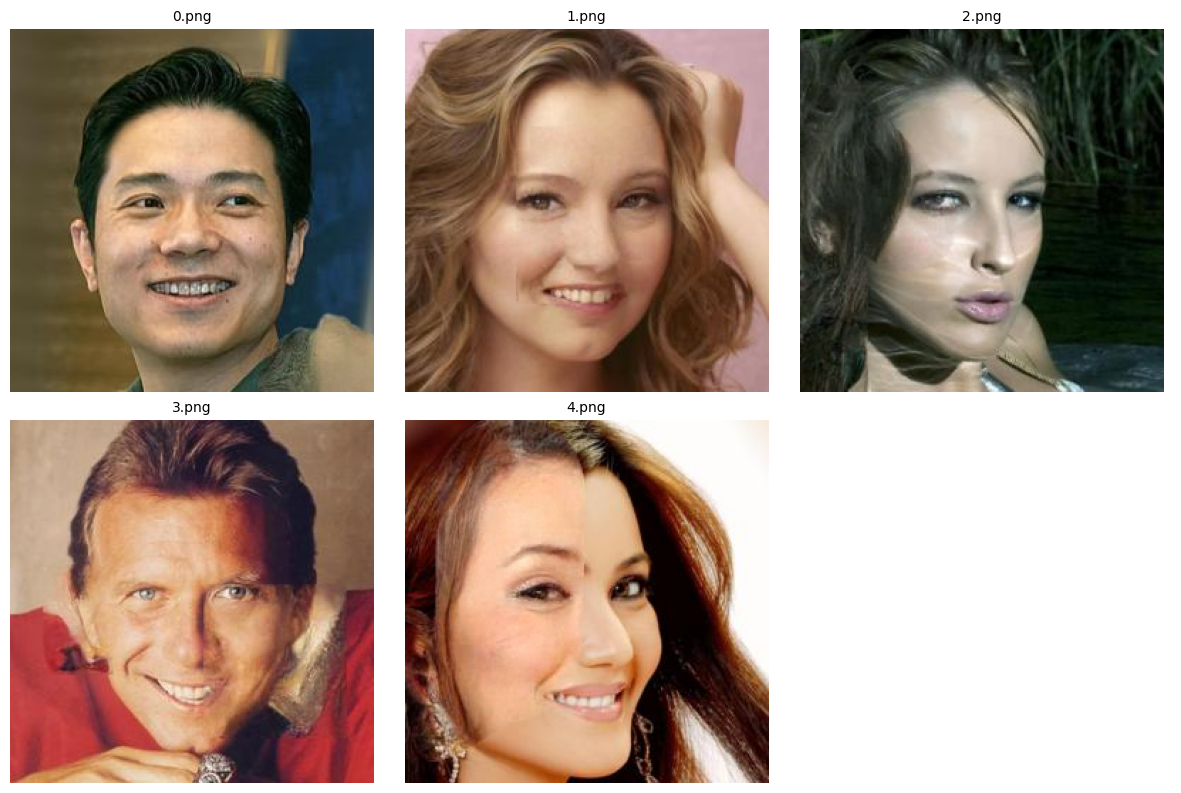

In [24]:
show_images_grid('/kaggle/working/p2w/experiments/celebahq/dpmsolver++_multistep_order3_250_time_uniform_type-dpmsolver/image_samples/results/celebahq/thick/outImg')

In [25]:
metric_str = '# === Metric Imports ===\n'\
'from lpips import LPIPS\n'\
'import torch\n'\
'import torch.nn.functional as F\n'\
'from math import log10\n'\
'from torchmetrics.functional.image import structural_similarity_index_measure\n'\
'from PIL import Image\n'\
'from torchvision import transforms\n'\
'import os\n'\
'import sys\n'\
'import io\n'\
'import subprocess\n'\
'os.environ["TORCH_HOME"] = "/kaggle/working/p2w/.cache/torch/"\n'\
'\n'\
'# === Install FID if not installed ===\n'\
'#!pip install -q pytorch-fid\n'\
'\n'\
'# === Metric Calculation Functions ===\n'\
'def check_range(img):\n'\
'    assert torch.min(img) >= -1.0, "Minimum pixel value is less than -1.0"\n'\
'    assert torch.max(img) <= 1.0, "Maximum pixel value is greater than 1.0"\n'\
'def calculate_lpips(img1, img2):\n'\
'    check_range(img1)\n'\
'    check_range(img2)\n'\
'    lpips_model = LPIPS(net="alex", model_path="/kaggle/working/p2w/.cache/lpips/alex.pth").to(img2.device)\n'\
'    return lpips_model(img1.to(img2.device), img2).item()\n'\
'def calculate_ssim(img1, img2):\n'\
'    check_range(img1)\n'\
'    check_range(img2)\n'\
'    img1 = (img1 + 1.0) / 2.0\n'\
'    img2 = (img2 + 1.0) / 2.0\n'\
'    return structural_similarity_index_measure(img1.to(img2.device), img2)\n'\
'def calculate_psnr(img1, img2):\n'\
'    check_range(img1)\n'\
'    check_range(img2)\n'\
'    img1 = (img1 + 1.0) / 2.0\n'\
'    img2 = (img2 + 1.0) / 2.0\n'\
'    mse = F.mse_loss(img1, img2)\n'\
'    return 20 * log10(1.0 / torch.sqrt(mse))\n'\
'def calculate_l1(img1, img2):\n'\
'    check_range(img1)\n'\
'    check_range(img2)\n'\
'    img1 = (img1 + 1.0) / 2.0\n'\
'    img2 = (img2 + 1.0) / 2.0\n'\
'    return F.l1_loss(img1, img2).item()\n'\
'def normalize_to_neg1_1(t):\n'\
'    return t * 2 - 1\n'\
'def avg(lst): return sum(lst) / len(lst) if lst else 0\n'\
'# === Set Paths ===\n'\
'gt_dir = \'/kaggle/working/p2w/experiments/celebahq/dpmsolver++_multistep_order3_250_time_uniform_type-dpmsolver/image_samples/results/celebahq/thick/gtImg\'\n'\
'out_dir = \'/kaggle/working/p2w/experiments/celebahq/dpmsolver++_multistep_order3_250_time_uniform_type-dpmsolver/image_samples/results/celebahq/thick/outImg\'\n'\
'output_path = "/kaggle/working/inpainting_metrics_report.txt"\n'\
'# === Redirect Print to File ===\n'\
'f = open(output_path, "w")\n'\
'sys.stdout = io.TextIOWrapper(open(output_path, \'wb\'))\n'\
'# === Preprocessing ===\n'\
'transform = transforms.Compose([\n'\
'    transforms.ToTensor(),\n'\
'    transforms.Resize((256, 256)),\n'\
'])\n'\
'lpips_model = LPIPS(net="alex", model_path="/kaggle/working/p2w/.cache/lpips/alex.pth")\n'\
'lpips_scores, ssim_scores, psnr_scores, l1_scores = [], [], [], []\n'\
'filenames = sorted([\n'\
'    f for f in os.listdir(out_dir)\n'\
'    if f.lower().endswith((\'.png\', \'.jpg\', \'.jpeg\'))\n'\
'])\n'\
'print(f" Found {len(filenames)} image pairs to evaluate.\\n")\n'\
'for fname in filenames:\n'\
'    path_out = os.path.join(out_dir, fname)\n'\
'    path_gt = os.path.join(gt_dir, fname)\n'\
'    if not os.path.exists(path_gt):\n'\
'        print(f" Missing ground truth for: {fname}, skipping.")\n'\
'        continue\n'\
'    try:\n'\
'        img_out = normalize_to_neg1_1(transform(Image.open(path_out).convert("RGB")).unsqueeze(0))\n'\
'        img_gt = normalize_to_neg1_1(transform(Image.open(path_gt).convert("RGB")).unsqueeze(0))\n'\
'        lpips_val = lpips_model(img_out.to(img_gt.device), img_gt.to(img_gt.device)).item()\n'\
'        ssim_val = calculate_ssim(img_out, img_gt)\n'\
'        psnr_val = calculate_psnr(img_out, img_gt)\n'\
'        l1_val = calculate_l1(img_out, img_gt)\n'\
'        lpips_scores.append(lpips_val)\n'\
'        ssim_scores.append(ssim_val.item() if torch.is_tensor(ssim_val) else ssim_val)\n'\
'        psnr_scores.append(psnr_val)\n'\
'        l1_scores.append(l1_val)\n'\
'    except Exception as e:\n'\
'        print(f" Error on {fname}: {e}")\n'\
'# === Print Final Results ===\n'\
'print("\\n Overall Evaluation Results:")\n'\
'print(f"LPIPS : {avg(lpips_scores):.4f} ↓ (lower is better)")\n'\
'print(f"SSIM  : {avg(ssim_scores):.4f} ↑ (higher is better)")\n'\
'print(f"PSNR  : {avg(psnr_scores):.2f} dB ↑ (higher is better)")\n'\
'print(f"L1    : {avg(l1_scores):.4f} ↓ (lower is better)")\n'\
'# === FID Calculation (CLI) ===\n'\
'print("\\n Running FID Calculation using pytorch-fid...")\n'\
'try:\n'\
'    result = subprocess.run(\n'\
'        ["python", "-m", "pytorch_fid", gt_dir, out_dir],\n'\
'        capture_output=True, text=True\n'\
'    )\n'\
'    if result.returncode == 0:\n'\
'        fid_output = result.stdout.strip()\n'\
'        print(f"FID   : {fid_output.splitlines()[-1]} ↓ (lower is better)")\n'\
'    else:\n'\
'        print(" FID calculation failed:", result.stderr.strip())\n'\
'except Exception as e:\n'\
'    print(f" FID subprocess error: {e}")\n'\
'# === Restore Output ===\n'\
'sys.stdout = sys.__stdout__\n'\
'print(f"\\n Report saved to: {output_path}")\n'
with open('/kaggle/working/p2w/metrics.py', 'w') as f:
    f.write(metric_str)
print("Successfully wrote metrics.py to /kaggle/working/p2w/metrics.py")

Successfully wrote metrics.py to /kaggle/working/p2w/metrics.py


In [26]:
!source /kaggle/working/miniconda/etc/profile.d/conda.sh && conda activate p2wd && \
cd /kaggle/working/p2w && python metrics.py

/kaggle/working/miniconda/envs/p2wd/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/kaggle/working/miniconda/envs/p2wd/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)

 Report saved to: /kaggle/working/inpainting_metrics_report.txt


In [27]:
import os
import zipfile
from pathlib import Path

# Define the directory containing the images (Kaggle path)
image_dir = '/kaggle/working/p2w/experiments/celebahq/dpmsolver++_multistep_order3_250_time_uniform_type-dpmsolver/image_samples/results/celebahq/thick'

# Output path for the ZIP file (in Kaggle's writable directory)
output_dir = '/kaggle/working'
zip_name = os.path.join(output_dir, f'mdii_multistep_order3_250_time_uniform_type_nocfs_256_celebahq_thick.zip')

# Function to collect all image files
def collect_images(directory):
    image_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif')  # Add more extensions if needed
    image_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(image_extensions):
                image_files.append(os.path.join(root, file))
    return image_files

# Function to zip images
def zip_images(image_files, zip_path):
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for file in image_files:
            zipf.write(file, os.path.relpath(file, image_dir))
    print(f"Images zipped as {zip_path}")

# Collect all images
image_files = collect_images(image_dir)
print(f"Found {len(image_files)} images in {image_dir}")

# Zip all images
zip_images(image_files, zip_name)

print(f"ZIP file created at {zip_name}. Download it from the Kaggle output panel.")

Found 20 images in /kaggle/working/p2w/experiments/celebahq/dpmsolver++_multistep_order3_250_time_uniform_type-dpmsolver/image_samples/results/celebahq/thick
Images zipped as /kaggle/working/mdii_multistep_order3_250_time_uniform_type_nocfs_256_celebahq_thick.zip
ZIP file created at /kaggle/working/mdii_multistep_order3_250_time_uniform_type_nocfs_256_celebahq_thick.zip. Download it from the Kaggle output panel.
